#**Using Spotify and Pitchfork Data to find out what makes songs and albums successful**

The question of what makes a song *good* is one that we're each interested in but one that we never thought we could reasonably answer. With the tools learned in CIS 545 and ample availability of data, we realized we could finally try and figure this out. Our project is focused on using data from Spotify and Pitchfork album reviews to analyze and predict the success of a song.

Additionally, we also intend to explore various interesting trends and patterns in the data we have found. Our goal is to ultimately run regressions, random forests, as well as boosting to predict the success of songs and albums as well as to classify whether a particular song or album will be "good" or not.

In order to do this, we used two datasets from Kaggle - one that contained Spotify songs and associated attributes such as their valence, tempo, acousticeness, danceability, loudness, etc. We also used a second dataset that contained Pitchfork reviews for albums, including both, a descriptive review of the album as well as a score from 0 to 10 given by Pitchfork critics.

#**Extracting Data**

##Imports

We started by importing spotipy, the API to pull data from Spotify about songs and albums, as well as importing pandas and afinn for sentiment analysis.

In [ ]:
# pip installations 
!pip3 install spotipy
!pip3 install pandas
!pip install afinn

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 153kB 31.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=c5673aa8d2b7a1c9cb5aa55e66ab10a1b3ccf8784c2f1490dbada7f256b27163
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [ ]:
# imports
import time
from datetime import datetime
import os
import requests

import spotipy
import pandas as pd
import sqlite3

from google.colab import files
from google.colab import drive

## Mounting Drive

In order to mount our Google Drive onto the Notebook so that we did not need to repeatedly fetch data from Spotify, we wrote code that allowed the Notebook to pull data from different users' Google Drive which we could control by simply uncommenting the name of the current user.

**Important Note for the TA**

*You can find the files used for our project on this link:*
https://drive.google.com/drive/u/1/folders/1wK1KcDzeJ26mZWqTwFlPCQoSJCqQmqll?fbclid=IwAR0twYNnuMdUU-PFiYXpSZy3P-8fyoRW8t0-LULG7t840NC85PhiHNyqf4o

*To run the code you can go to the link above and download the files onto your own google drive. Then replace the None in the cell below with the path to the files. This code should then run seamlessly*


In [ ]:
# mount drive to colab enviroment
DRIVE_MOUNT = '/content/gdrive'
drive.mount(DRIVE_MOUNT)

Mounted at /content/gdrive


In [ ]:
# set drive path based on current user

'''UNCOMMENT YOUR NAME'''
# current_user = 'Zach'
# current_user = 'Anshul'
# current_user = 'Gantavya'
current_user = 'TA'

if current_user == 'Zach':
  drive_path = 'CIS 545/CIS 545 Project/files_for_colab'
elif current_user == 'Anshul':
  drive_path = 'CIS 545 Project/files_for_colab'
elif current_user == 'Gantavya':
  drive_path = '/content/gdrive/MyDrive/CIS 545 Project/files_for_colab'
else:
  drive_path = None # Replace None with the path to files for colab on your google drive

drive_path = os.path.join(DRIVE_MOUNT, 'MyDrive', drive_path)

print(f'current_user: {current_user}')
print(f'drive_path: {drive_path}')

ls_result = !ls "$drive_path"
print(f'available files at drive_path: {ls_result[0]}')

current_user: Gantavya
drive_path: /content/gdrive/MyDrive/CIS 545 Project/files_for_colab
available files at drive_path: audio_features.csv  pitchfork_reviews.sqlite  songs.csv


In [ ]:
if current_user != 'Zach':
  # mount drive to colab enviroment
  DRIVE_MOUNT = '/content/gdrive'
  drive.mount(DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data Acquisition and Wrangling

### Extracting Data from SQLITE Database

This next section extracts 2 dataframes from a .db file that we downloaded from [kaggle](https://www.kaggle.com/nolanbconaway/pitchfork-data). One of these datasets contains data about reviews of 18393 reviews of music albums. The other dataset contains the actual text content of these reviews.

The data was given in a .db file, so we used the sqlite3 library to create a connection to the database and then used SQL statements  with Pandas in order to extract the relevant tables from the database. We extracted one dataframe that had information about each review, such as author, date, and score, and another dataframe that had the text content of each review

In [ ]:
# connect to kaggle database
pitchfork_path = os.path.join(drive_path, 'pitchfork_reviews.sqlite')
print(pitchfork_path)
print(os.path.isfile(pitchfork_path))

conn = sqlite3.connect(pitchfork_path)

/content/gdrive/MyDrive/CIS 545 Project/files_for_colab/pitchfork_reviews.sqlite
True


In [ ]:
# get CSV from database
reviews_df = pd.read_sql('SELECT * from reviews', conn)
reviews_df['album_id'] = reviews_df.index  # this is the key between songs_df and reviews_df
reviews_df

reviewid                        title  ... pub_year album_id
0         22703                    mezzanine  ...     2017        0
1         22721                 prelapsarian  ...     2017        1
2         22659         all of them naturals  ...     2017        2
3         22661                  first songs  ...     2017        3
4         22725                    new start  ...     2017        4
...         ...                          ...  ...      ...      ...
18388      1535               let us replay!  ...     1999    18388
18389      1341                         1999  ...     1999    18389
18390      5376                  out of tune  ...     1999    18390
18391      2413  singles breaking up, vol. 1  ...     1999    18391
18392      3723    left for dead in malaysia  ...     1999    18392

[18393 rows x 14 columns]

In [ ]:
# get CSV from database
content_df = pd.read_sql('SELECT * from content', conn)
content_df

reviewid                                            content
0         22703  “Trip-hop” eventually became a ’90s punchline,...
1         22721  Eight years, five albums, and two EPs in, the ...
2         22659  Minneapolis’ Uranium Club seem to revel in bei...
3         22661  Kleenex began with a crash. It transpired one ...
4         22725  It is impossible to consider a given release b...
...         ...                                                ...
18388      1535  The marketing guys of yer average modern megac...
18389      1341  Well, it's been two weeks now, and I guess it'...
18390      5376  Out of Tune is a Steve Martin album.  Yes, I'l...
18391      2413  Well, kids, I just went back and re-read my re...
18392      3723  Neil Hamburger's third comedy release is a des...

[18393 rows x 2 columns]

###Sentiment Analysis

Next, we decided to run a sentiment analysis on the content of the album reviews to gauge whether the review about the album included mostly positive or mostly negative sentiment towards the album. Ultimately this would serve as an important label for us to predict and classify since it would allow us to determine whether a given album (assortment of songs) will be met with positive reactions or negative reactions. 

In [ ]:
from afinn import Afinn

We found some weird characters so we decided to write a function that gets rid of these.

In [ ]:
#Start by defining a function that removes undesireable characters from the text.
import re

def remove_bad_patterns(text):
    """Remove html, latex, and newline characters from a string
    
    :param text: content as a string
    :return: cleaned text string
    """
    text = re.sub("\xa0","", text)
    return text

In [ ]:
#Extract relevant text content from the df containing content
review_content = content_df['content']

In [ ]:
#For eacxh entry in the review content, remove bad patterns
cleaned_review_content = pd.Series([remove_bad_patterns(row) for row in review_content])

In [ ]:
#Add a column to content_df that includes the sentiment analysis score based on cleaned review content
afinn = Afinn(language = 'en')
content_df['review_score'] = cleaned_review_content.apply(afinn.score)

### Acquire Album Data from Spotify APIs

We used the Spotify API to collect another dataset to use together with the Pitchfork dataset. For each album in the reviews dataframe, we make a request to the Spotify API for information about that album. We take the oldest album matching our request to make sure we collect information on the original album and not any remixes. From this album information, we extract all songs that are in the album.

For each song we extracted, we make an additional request to the Spotify API for the song’s “audio features.” These features are metrics that spotify keeps for each song and uses in their recommendation system. These features include danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and time signature.


In [ ]:
api_credentials = {
  'cid': 'your cid here',
  'secret': 'your secret here',
}

In [ ]:
# given an artist name and album name, returns list of track dictionaries comprised of all tracks in given album
def get_track_objects(sp, artist_name, album_name):
    """
    these are all of the attributes on the track objects
    dict_keys(['album', 'artists', 'available_markets', 'disc_number',
               'duration_ms', 'explicit', 'external_ids',
               'external_urls', 'href', 'id', 'is_local', 'name', 'popularity',
               'preview_url', 'track_number', 'type',
               'uri'])
    """
    results = sp.search(q='artist:{0} album:{1}'.format(artist_name, album_name), type='track', limit=50)
    try:
        # this gets oldest album to filter out remixes
        best_album_uri = min(results['tracks']['items'], key=lambda x: datetime.strptime(x['album']['release_date'], '%Y-%m-%d'))['album']['uri']
    except ValueError:
        return []
    tracks = [item for item in results['tracks']['items'] if item['album']['uri'] == best_album_uri]
    return tracks

In [ ]:
def get_songs():
  global api_credentials
  client_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id=api_credentials['cid'], client_secret=api_credentials['secret'])
  sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

  reviews_df = pd.read_csv('reviews.csv')
  reviews_df = reviews_df[reviews_df['title'].notna() & reviews_df['artist'].notna()]

  havent_written = True
  rows_to_write = []

  for index, row in reviews_df.iterrows():
      if index % 100 == 0:
          print(index)

      tracks = get_track_objects(sp, row['artist'], row['title'])
      for track in tracks:
          rows_to_write.append({
              'album_id': row['album_id'],
              'album_title': row['title'],
              'artist': row['artist'],
              'song_title': track['name'],
              'disc_number': track['disc_number'],
              'duration_ms': track['duration_ms'],
              'explicit': track['explicit'],
              'external_ids': track['external_ids'],
              'external_urls': track['external_urls'],
              'href': track['href'],
              'sp_id': track['id'],
              'popularity': track['popularity'],
              'track_number': track['track_number'],
          })

      if (index + 1) % 200 == 0:
          songs_df = pd.DataFrame(rows_to_write)
          songs_df.to_csv('songs.csv', mode='a', sep=',', encoding='utf-8', index=False,
                          header=havent_written)
          havent_written = False
          rows_to_write = []
          print('wrote batch {0}'.format((index + 1) // 150))

In [ ]:
# given a list of track dicts, returns audio features for each track
def get_tracks_audio_features(sp, tracks):
    if len(tracks) > 0 and not isinstance(tracks[0], str):
        tracks = [track['uri'].split(':')[-1] for track in tracks]
    audio_features = sp.audio_features(tracks)
    return audio_features

In [ ]:
def get_song_attributes():
    global api_credentials
    client_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id=api_credentials['cid'], client_secret=api_credentials['secret'])
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    song_ids = list(pd.read_csv('songs_1618340729.csv')['sp_id'])

    rows_to_write = []
    havent_written = True
    chunk_size = 10

    index = 0
    while index < len(song_ids):
        print('{0} / {1}'.format(index, len(song_ids)))

        song_ids_subset = song_ids[index: min(index+chunk_size, len(song_ids)-1)]
        index += chunk_size
        audio_track_features = get_tracks_audio_features(sp, song_ids_subset)
        rows_to_write += audio_track_features

        if index % 200 == 0:
            print('Writing batch #{0}'.format(index))
            try:
                songs_df = pd.DataFrame([row for row in rows_to_write if row is not None])
                songs_df.drop(['uri', 'type'], axis=1, inplace=True)
                songs_df.to_csv('audio_features.csv', mode='a', sep=',', encoding='utf-8',
                                index=False, header=havent_written)
            except Exception as e:
                print(e)

            havent_written = False
            rows_to_write = []
            print('Sleeping for 2.5 seconds to not overwhelm API...')
            time.sleep(2.5)

These next 2 cells check if the data from Spotify is present in the Drive folder. If it is, we simply load that csv into memory. If it is not, we run the API wrapper code.

In [ ]:
# If the songs.csv file is not in your drive, this will run the API wrapper functions to create it

songs_filepath = os.path.join(drive_path, 'songs.csv')

if not os.path.isfile(songs_filepath):
  get_songs()
  songs_df = pd.read_csv('songs.csv')
else:
  songs_df = pd.read_csv(songs_filepath)

songs_df

album_id album_title  ... popularity track_number
0              0   mezzanine  ...         71            3
1              0   mezzanine  ...         63            1
2              0   mezzanine  ...         54            8
3              0   mezzanine  ...         53            6
4              0   mezzanine  ...         52            5
...          ...         ...  ...        ...          ...
135169     18198  fly pan am  ...         18            1
135170     18198  fly pan am  ...          9            2
135171     18198  fly pan am  ...          8            3
135172     18198  fly pan am  ...          7            4
135173     18198  fly pan am  ...          8            5

[135174 rows x 13 columns]

In [ ]:
# If the audio_features.csv file is not in your drive, this will run the API wrapper functions to create it

audio_features_filepath = os.path.join(drive_path, 'audio_features.csv')

if not os.path.isfile(audio_features_filepath):
  get_song_attributes()
  audio_features_df = pd.read_csv('audio_features.csv')
else:
  audio_features_df = pd.read_csv(audio_features_filepath)

audio_features_df

danceability  energy  ...  duration_ms  time_signature
0              0.615   0.419  ...       330773               4
1              0.714   0.309  ...       379533               4
2              0.560   0.455  ...       381667               4
3              0.646   0.602  ...       366893               4
4              0.705   0.210  ...       251200               4
...              ...     ...  ...          ...             ...
134989         0.599   0.700  ...       262853               4
134990         0.664   0.941  ...       233213               4
134991         0.667   0.839  ...       302947               4
134992         0.650   0.676  ...        94467               4
134993         0.604   0.953  ...       338840               4

[134994 rows x 16 columns]

### Merge Data from Reviews and Spotify

At this point, we have four dataframes. One for the album review information, one for the review content, one for the song information, and one for the song audio features. In this next cell, we merge the four dataframes into one.

In [ ]:
# merge all 4 dataframes into 1
df = songs_df.merge(reviews_df, on='album_id')  # merge songs with review info
df = df.merge(audio_features_df, left_on='sp_id', right_on='id')  # merge that with audio features
df = df.merge(content_df, on='reviewid')  # merge that with review content
df

album_id  ... review_score
0              0  ...         -9.0
1              0  ...         -9.0
2              0  ...         -9.0
3              0  ...         -9.0
4              0  ...         -9.0
...          ...  ...          ...
136599     18170  ...         46.0
136600     18170  ...         46.0
136601     18170  ...         46.0
136602     18170  ...         46.0
136603     18170  ...         46.0

[136604 rows x 44 columns]

### Cleaning and Filtering Data

Next, we remove redundant columns that exist after the join as well as certain columns that have no predictive power or relevance to our analysis such as the URL to the album/song and which disc the song was a part of within the album.

In [ ]:
df = df[df['duration_ms_x'] == df['duration_ms_y']]  # get rid of songs with weird name stuff (just 2 in our data set)
columns_to_drop = ['artist_y', 'duration_ms_y']  # duplicate columns. slight discrepencies between artist names (taken care of above) and durations are all off by 1ms so it doesn't really matter
columns_to_drop += ['disc_number', 'external_ids', 'external_urls', 'href', 'track_number', 'url', 'id', 'track_href', 'analysis_url']
df.drop(columns_to_drop, axis=1, inplace=True)
df.rename({'artist_x': 'artist', 'duration_ms_x': 'duration_ms', 'content': 'review_content'}, axis=1, inplace=True)
df


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


album_id  ... review_score
0              0  ...         -9.0
1              0  ...         -9.0
3              0  ...         -9.0
4              0  ...         -9.0
5              0  ...         -9.0
...          ...  ...          ...
136594     18170  ...         46.0
136597     18170  ...         46.0
136599     18170  ...         46.0
136600     18170  ...         46.0
136603     18170  ...         46.0

[86630 rows x 33 columns]

In [ ]:
# convert the "explicit" column which indicated whether a song is explicit to an int
df['explicit'] = df['explicit'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#**EDA**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



We start by exploring the distributions of our three labels that we are trying to predict. These are the review score from the sentiment analysis on review text, the actual Pitchfork score from 0 to 10, and the popularity of the song on Spotify based on number of listens from users. This will help us better understand whether our data is evenly distributed or skewed.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


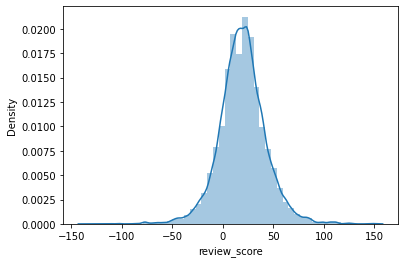

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


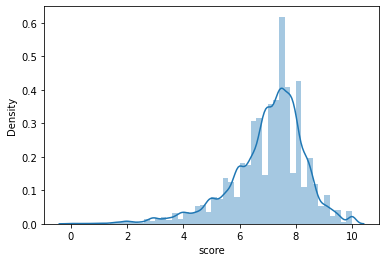

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


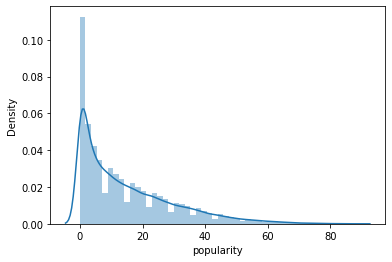

In [ ]:
sns.distplot(df['review_score']);
plt.show()

sns.distplot(df['score']);
plt.show()

sns.distplot(df['popularity']);
plt.show()

*We notice that the Review Score from Sentiment Analysis is evenly distributed around 0 and extends roughly from -150 to +150 wherein a higher score indicates a more positive sentiment associated with the review content.* 

*The Pitchfork Album score from 0-10 is left skewed since it peaks at around 7 rather than at 5.* This tells us that album reviews in our dataset are concentrated around the upper end of the spectrum and that there are fewer albums with scores close to 0. 

*Finally, looking at the Spotify popularity, we see that it extends from 0-100 and achieves a peak close to 0, hence it is heavily right skewed.* This might mean that the songs associated with the albums in our dataset are not usually ones that are very commercially popular with users.

Next, we try to see the correlation between different predictors associated with songs in our dataset. This is information about the audio associated with the song and its features as determined by Spotify. We also notice the distributions of each of the predictors to see if they skew a certain way.

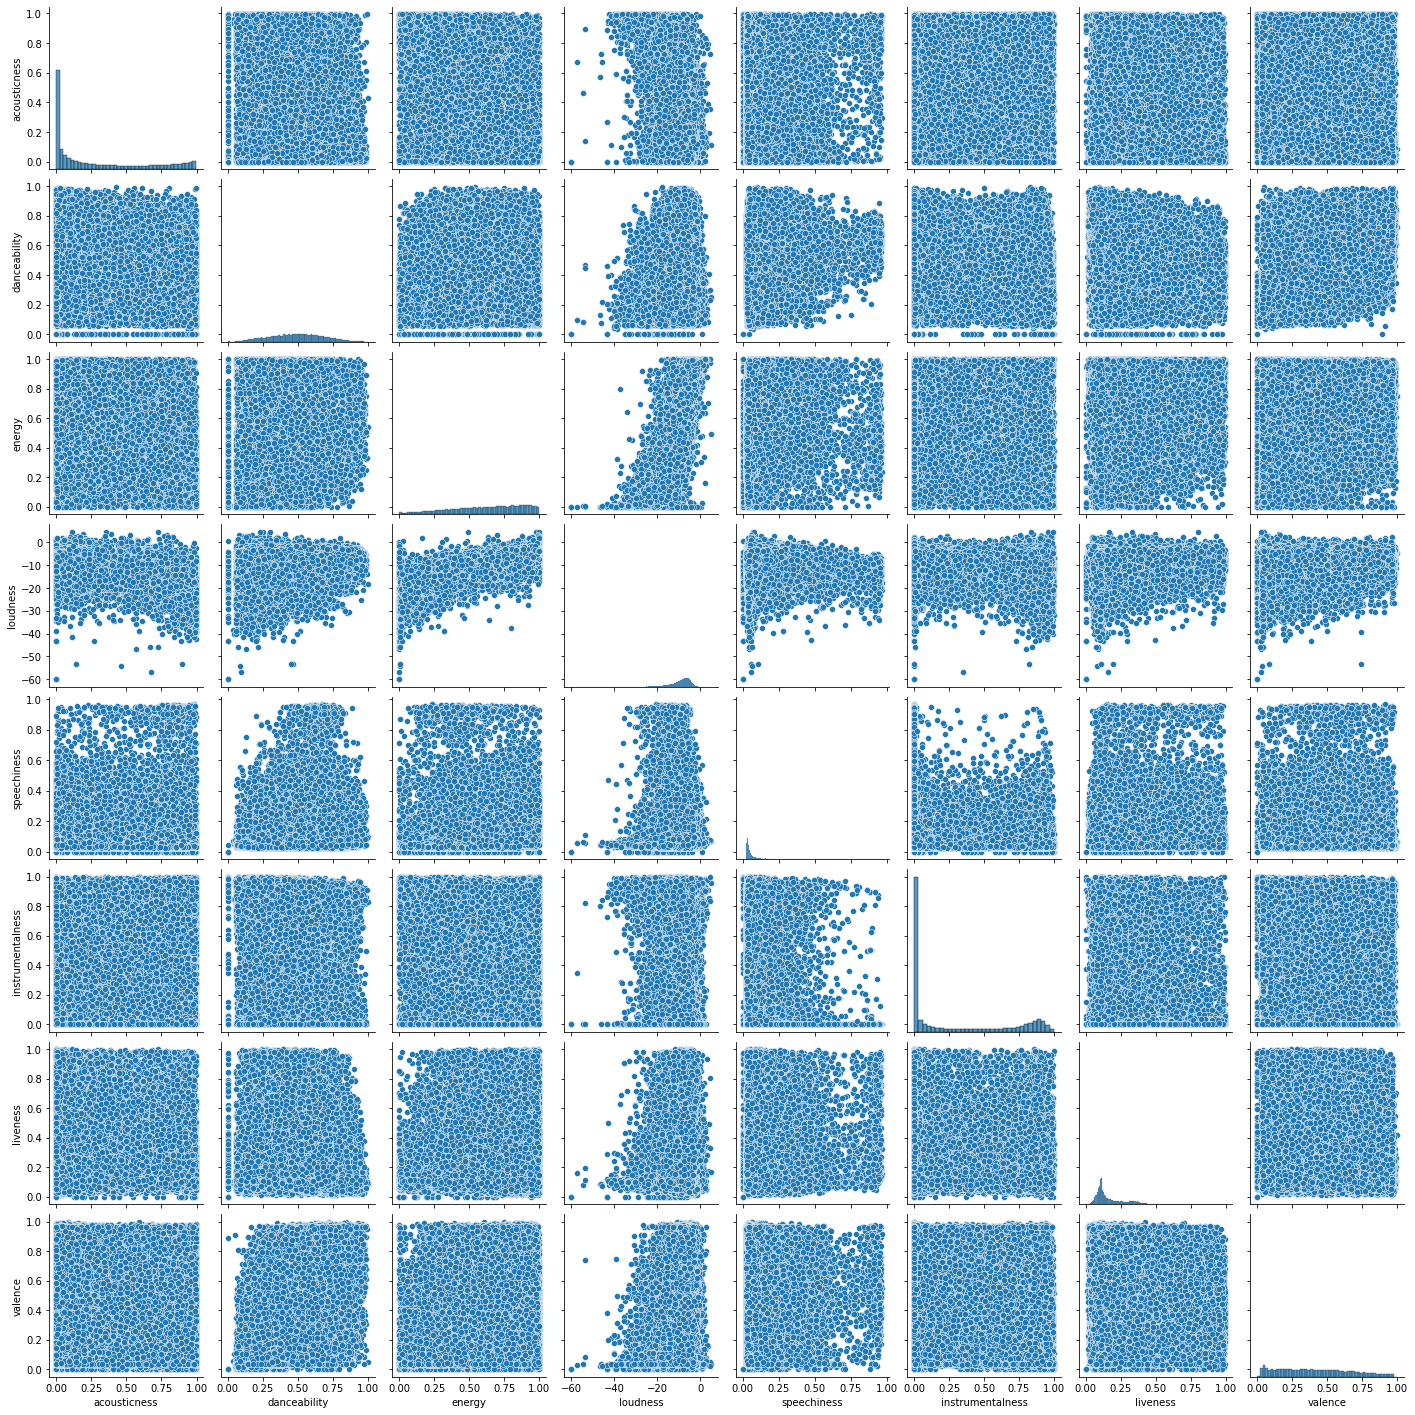

In [ ]:
df_predictors = df[['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence']]
sns.pairplot(df_predictors)

For the most part, there doesn't seem to be any particular correlation between any of the predictors. *There does seem to be an upward trend between energy and loudness which makes sense.*

In seeing the histograms for the predictors, we do however find that some predictors are highly skewed. *Acousticeness, Instrumentalness and liveness, for example, are very right skewed.*

We also check to see of there are any obvious and strong correlations between one of our predictors and one of our three labels. 

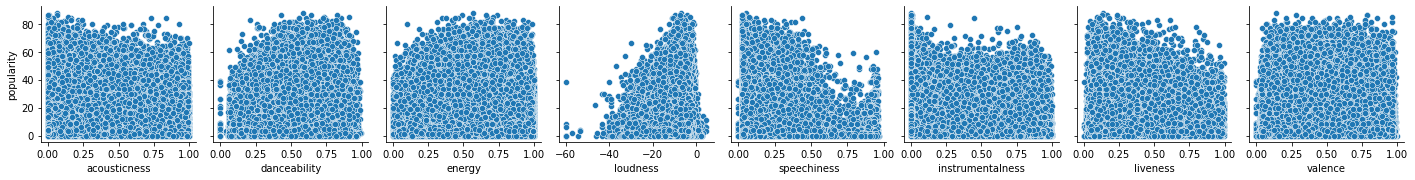

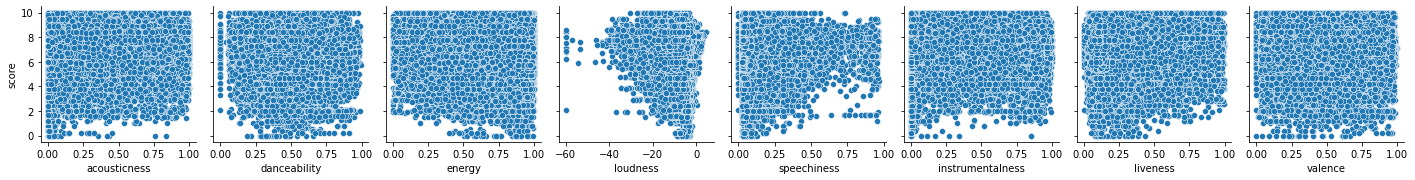

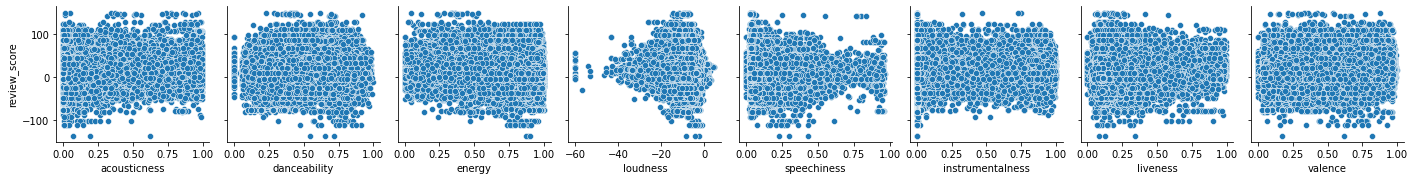

In [ ]:
sns.pairplot(df, x_vars= ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence'], y_vars = ['popularity'])
sns.pairplot(df, x_vars= ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence'], y_vars = ['score'])
sns.pairplot(df, x_vars= ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence'], y_vars = ['review_score'])

We can see from the plots above that while there are not any strong and clear correlations between predictors or between predictors and labels, we do see that certain predictors are heavily skewed in one direction or the other. To ammend this, we run a log transformation that will help us more evenly distribute the song attributes. Since most of the attributes are currently from 0-1, we add 1 to each attribute so that a log can be taken. Since Loudness goes from -60 to 0, we add 61 to make sure we can take a log.

In [ ]:
#rescale features
df['acousticness_log'] = np.log(df['acousticness'] + 1)
df['danceability_log'] = np.log(df['danceability'] + 1)
df['energy_log'] = np.log(df['energy'] + 1)
df['loudness_log'] = np.log(df['loudness'] + 61)
df['speechiness_log'] = np.log(df['speechiness'] + 1)
df['instrumentalness_log'] = np.log(df['instrumentalness'] + 1)
df['liveness_log'] = np.log(df['liveness'] + 1)
df['valence_log'] = np.log(df['valence'] + 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


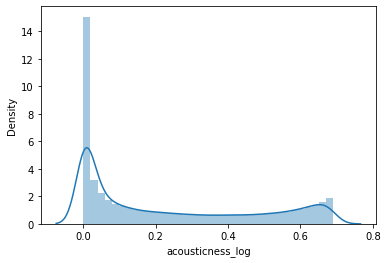

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


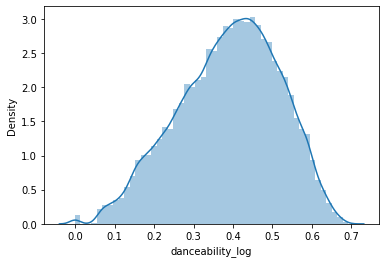

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


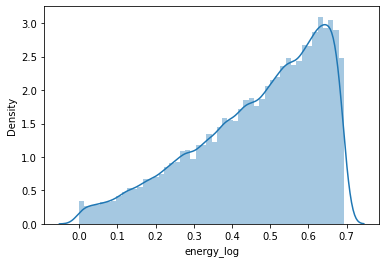

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


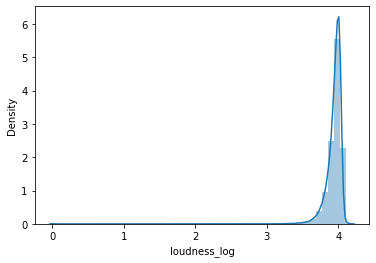

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


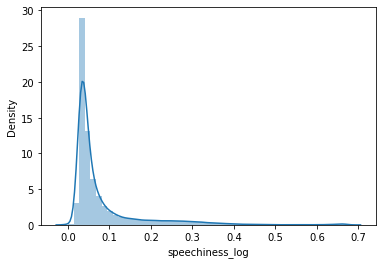

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


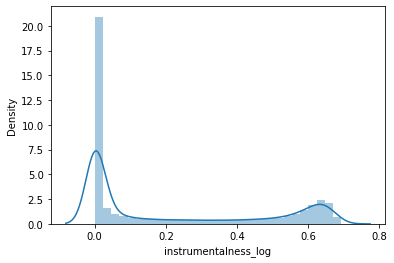

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


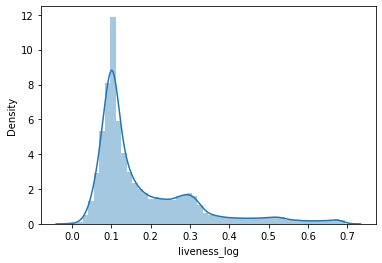

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


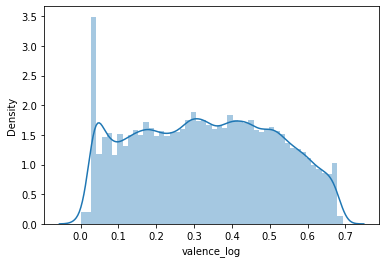

In [ ]:
sns.distplot(df['acousticness_log']);
plt.show()
sns.distplot(df['danceability_log']);
plt.show()
sns.distplot(df['energy_log']);
plt.show()
sns.distplot(df['loudness_log']);
plt.show()
sns.distplot(df['speechiness_log']);
plt.show()
sns.distplot(df['instrumentalness_log']);
plt.show()
sns.distplot(df['liveness_log']);
plt.show()
sns.distplot(df['valence_log']);
plt.show()



The graphs do show some improvement, but the data still doesn't seem normally distributed. We recognize this as a data problem, we just do not have enough distribution on predictors such as acousticeness and we accept that and move on.

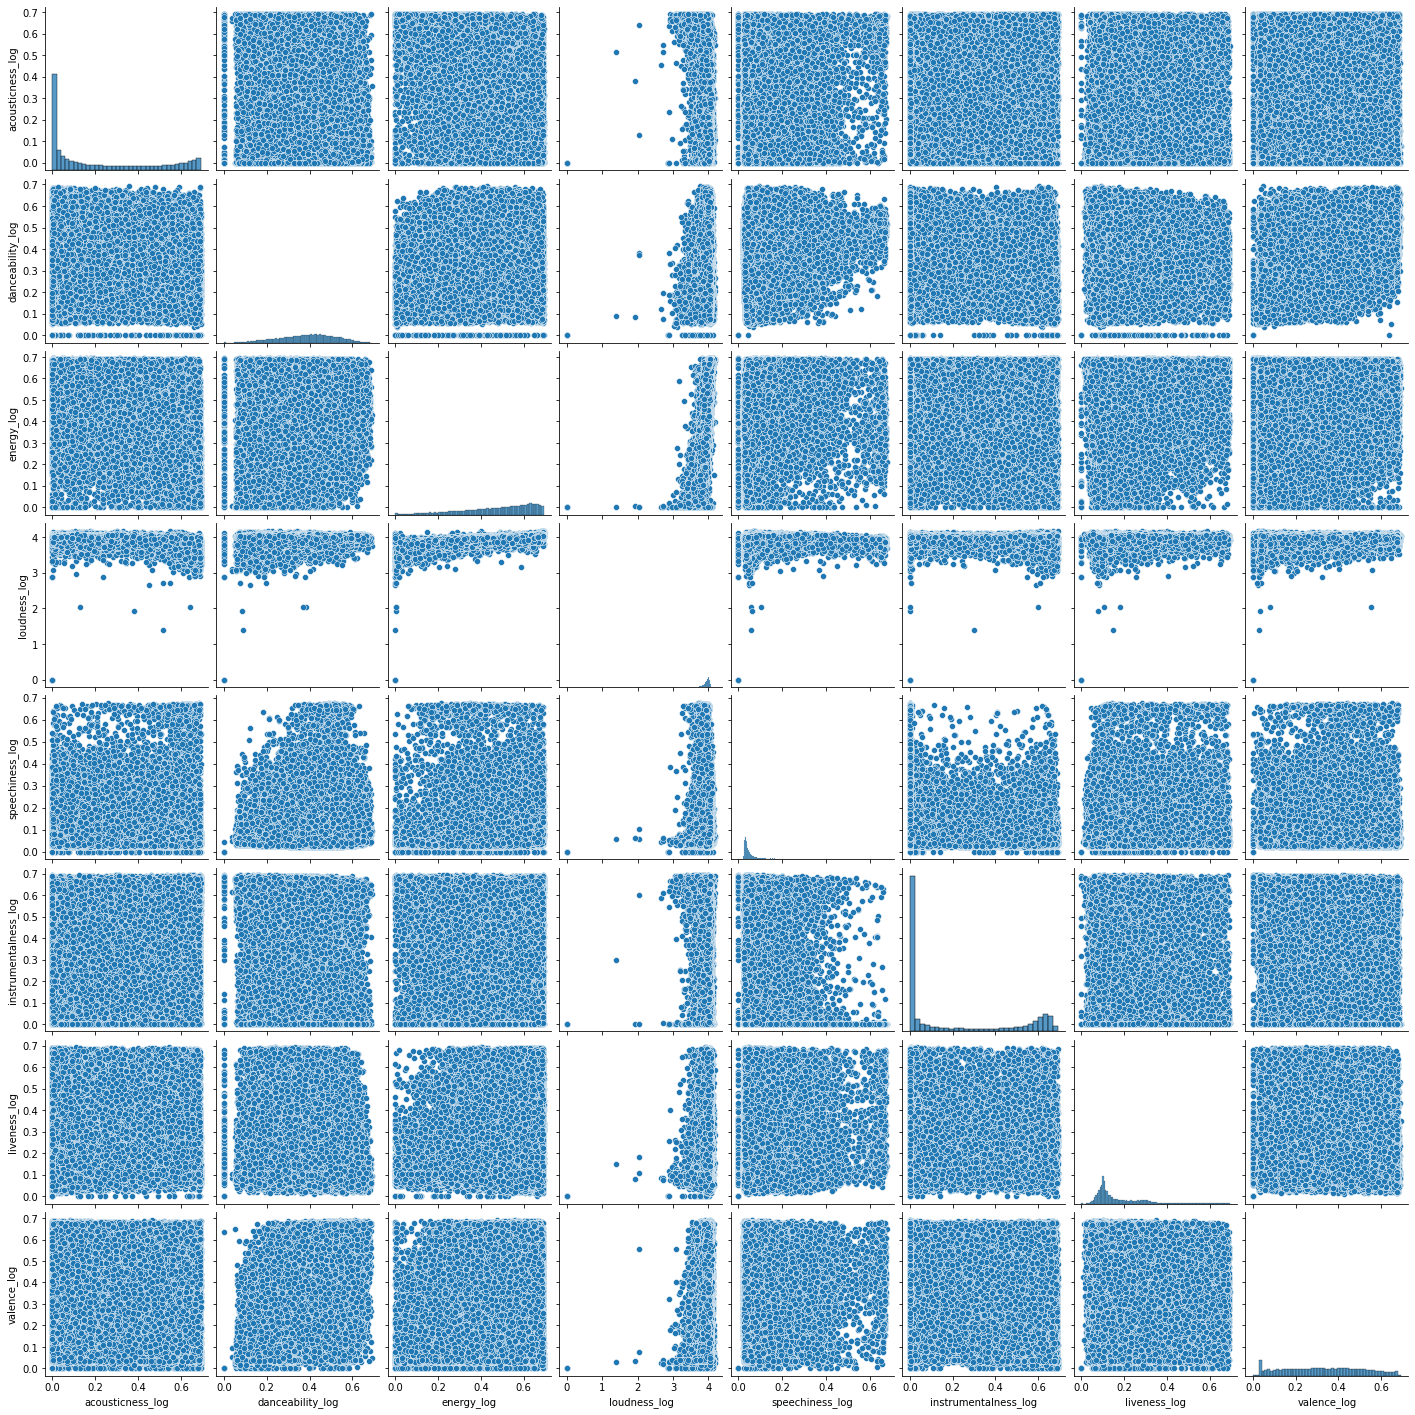

In [ ]:
df_log_predictors = df[['acousticness_log', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log']]
sns.pairplot(df_log_predictors)

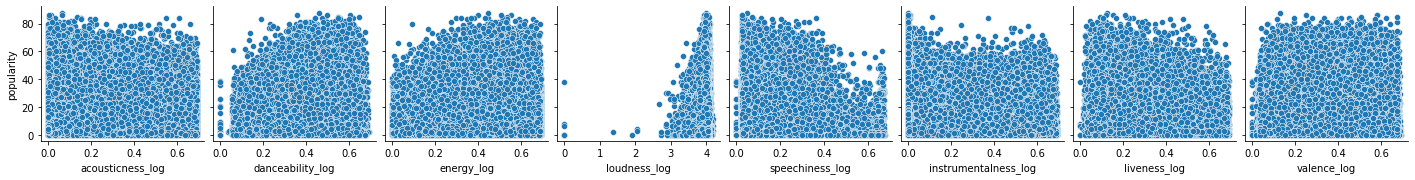

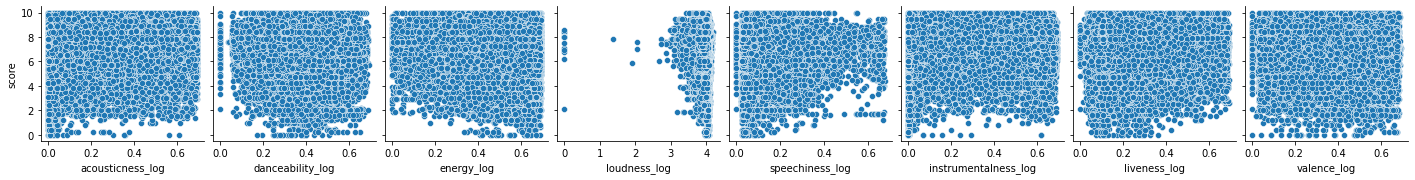

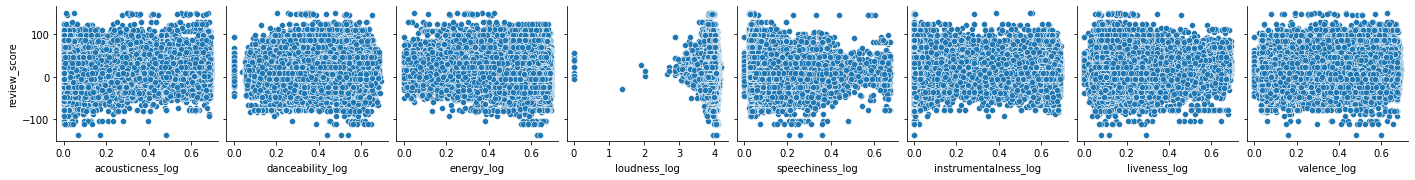

In [ ]:
sns.pairplot(df, x_vars = ['acousticness_log', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log'], y_vars = ['popularity'])
sns.pairplot(df, x_vars = ['acousticness_log', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log'], y_vars = ['score'])
sns.pairplot(df, x_vars = ['acousticness_log', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log'], y_vars = ['review_score'])

We can see that the distributions are slightly improved since the high peaks on either extreme of the distributions are now lower and the transformation has not imposed any cahnges in relationships amongst predictors as well as between predictors and labels. This is good for us because it means we can use the log transformed predictors instead of the normal ones.

##Most popular song by year

We try to find the most popular song played on Spotify based on the year it was published. *We can notice that the popularity is almost always in the 80s, which is far above the mean and median.* This makes sense. *We can also see some recognisable names here, including Coldplay, The Weeknd, Eminem, and a remaster of The Beatles.* 

In [ ]:
df.loc[df.groupby(['pub_year'])['popularity'].idxmax()]

album_id  ... valence_log
136591     18170  ...    0.390690
134744     17861  ...    0.250759
134260     17776  ...    0.389336
129716     16943  ...    0.508022
125181     16168  ...    0.278389
114913     14547  ...    0.570414
109379     13743  ...    0.116894
101399     12579  ...    0.127513
94238      11604  ...    0.400118
82498      10082  ...    0.348542
70640       8621  ...    0.332177
63264       7704  ...    0.495306
53665       6456  ...    0.675492
40910       4820  ...    0.134531
39453       4639  ...    0.581657
20798       2424  ...    0.459953
14048       1622  ...    0.128393
528           70  ...    0.452349
0              0  ...    0.195567

[19 rows x 41 columns]

Below, we can see the popularity of the most popular song each year on a bar graph. *It is worth noticing that these are roughly similar for each year*, meaning music from particular years is not necessarily more or less popular than music from other years. We notice that the *popularity is lower in 1999 and 2017* but this could possibly be because our dataset might start and end halfway in those years and therefore might not contain the "true" most popular song of that year.

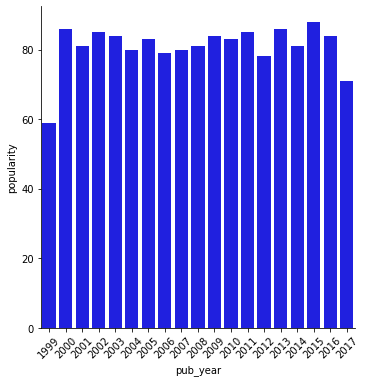

In [ ]:
g = sns.catplot(x = 'pub_year', y = 'popularity', kind = 'bar', data=df.loc[df.groupby(['pub_year'])['popularity'].idxmax()], color = 'blue')
g.set_xticklabels(rotation=45)


##Average spotify popularity v/s pitchfork rating


*We see that a vast majority of our songs and albums are clustered around a score of 7 on Pitchfork and a popularity on Spotify in the single digits.*

This goes to show that the number of songs with a good rating on Pitchfork is much larger than the number of popular songs on Spotify. Hence, success on Pitchfork doesn't guarantee that a song will be popular on Spotify.

This makes sense because there might be a large number of songs and albums that get reviewed favourably by Pitchfork critics but are too niche for the large Spotify user base.

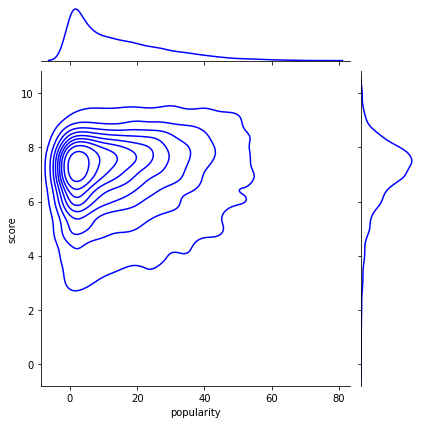

In [ ]:
sns.jointplot(x = 'popularity', y = 'score', data = df.groupby('album_title').mean(), color = "blue", kind = 'kde')

##Most Popular Artists

Next, we try to find the top 10 best artists based on Pitchfork Review Scores and Spotify popularity.

In [ ]:
artist_pop_df = df.groupby(['artist']).mean().reset_index()
best_scores_df = artist_pop_df.sort_values(by=['score'], ascending=False).head(10)
best_pop_df = artist_pop_df.sort_values(by=['popularity'], ascending=False).head(10)

print('Best Rated by Pitchfork')
print(best_scores_df)
print()
print('Most Popular on Spotify')
print(best_pop_df)
# artist_pop_df_grouped.iloc[artist_pop_df_grouped['score'].idxmax(5)]

Best Rated by Pitchfork
                                artist      album_id  ...  liveness_log  valence_log
4688                             slint   3214.000000  ...      0.086462     0.178526
2003                      glenn branca  15913.000000  ...      0.174772     0.173011
5016                        television  15383.000000  ...      0.106866     0.535430
3667                neutral milk hotel  13357.000000  ...      0.215647     0.207213
5501                   the stone roses   8614.000000  ...      0.257740     0.352644
4562                  serge gainsbourg   9181.000000  ...      0.094183     0.259436
4848                     stevie wonder    451.000000  ...      0.174725     0.454595
1158                           dangelo   4789.000000  ...      0.308612     0.384231
1606  elvis costello & the attractions  16623.434783  ...      0.150300     0.539652
528                     billie holiday  13652.000000  ...      0.097127     0.184818

[10 rows x 33 columns]

Most Popular on 

*It was extremely interesting to see absolutely no overlap in these top 10.* While Pitchfork gives us classic names like Stevie Wonder and Billie Holiday, the Spotify data suggests that these artists are not as popular as modern day ones such as Bruno Mars and Post Malone. *This might suggest that users of Spotify have different tastes than Pitchfork reviewers.* This makes sense because the audience using Spotify is likely a lot younger than the average reviewer for Pitchfork.

##Radar Chart

Our next goal in exploring the data was to create a radar chart that can visualize the weight of each attribute in the most popular artists and what they focus on most. 

We used the following functions to create radar charts to visualize the attributes of the songs created by the most popular artists. 

Important note: this code is very closely based upon code highlighted on the [Matplotlib website](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html).

In [ ]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# source for this code is: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

def radar_factory(num_vars, frame='circle'):
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
features = ['acousticness_log', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'instrumentalness_log', 'liveness_log', 'valence_log']
features.remove('loudness_log')
num_features = len(features)
theta = radar_factory(num_features)
spoke_labels = [feature.split('_')[0].title() for feature in features]

###Mean Song Features for Most Popular Artists on Spotify

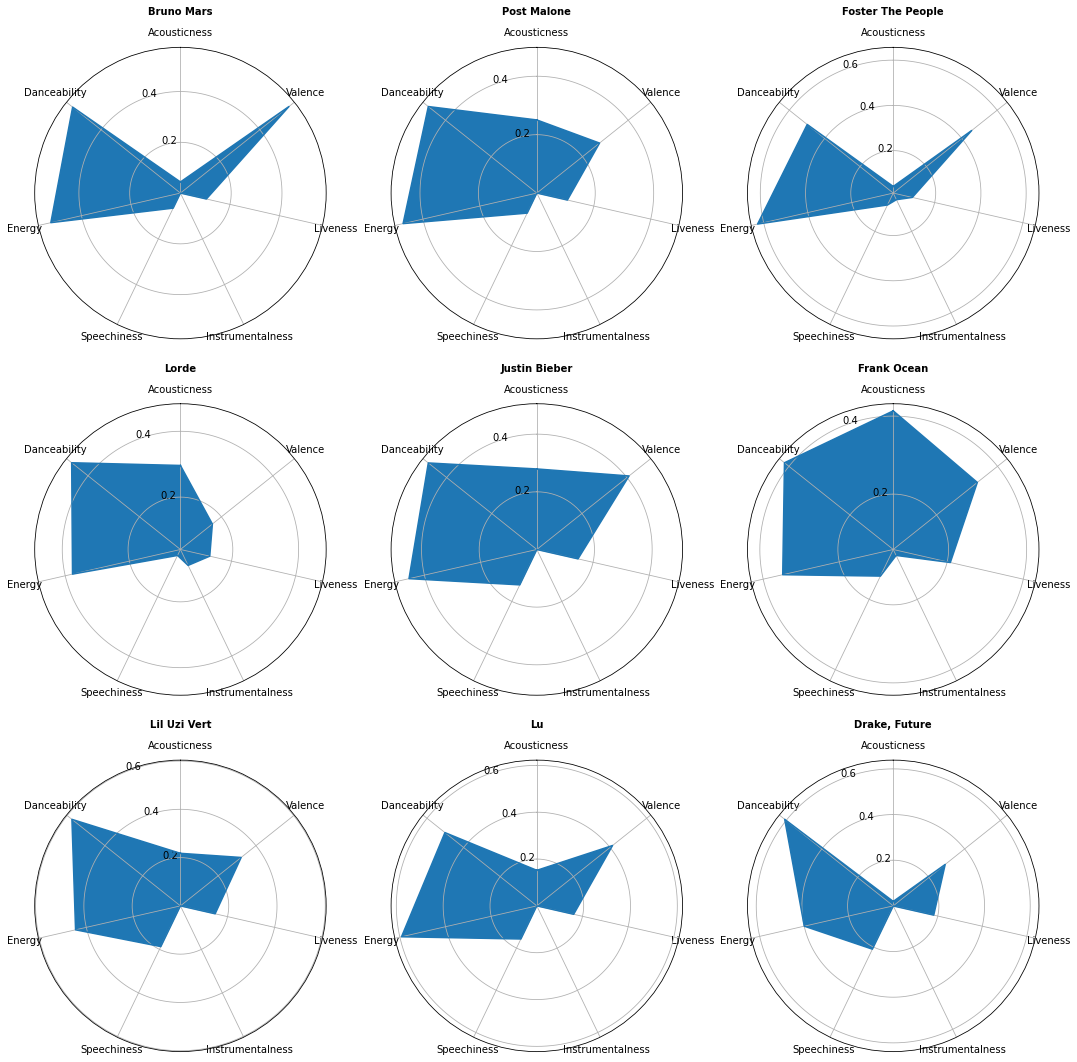

In [ ]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3, subplot_kw=dict(projection='radar'))

top_3_popular = best_pop_df[['artist'] + features].head(9).values.tolist()

for i, ax in enumerate(axs.flat):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(top_3_popular[i][0].title(), weight='bold', size='medium', position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')
        ax.plot(theta, top_3_popular[i][1:])
        ax.fill(theta, top_3_popular[i][1:])
        ax.set_varlabels(spoke_labels)

fig.tight_layout()
fig.show()


*We see that the most popular artists on Spotify seem to be ones that almost always have a very high danceability and a very low instrumentalness.* This makes sense since songs that are comprised of only instruments are usually classical music to which one cannot dance. *Further, energy was also a key common factor in successful artists on Spotify.* As such, this tells us that artists who put out energetic songs that are easy to dance to will see a lot more streams on Spotify than their counterparts with less energetic songs. 

This makes sense because Spotify popularity as an indicator is not necesarily correlated only with listener preferences, since Spotify might also get used in parties and events, for example, wherein energetic and danceable songs are necesary.

###Mean Song Features for Highest Rated Artists by Pitchfork

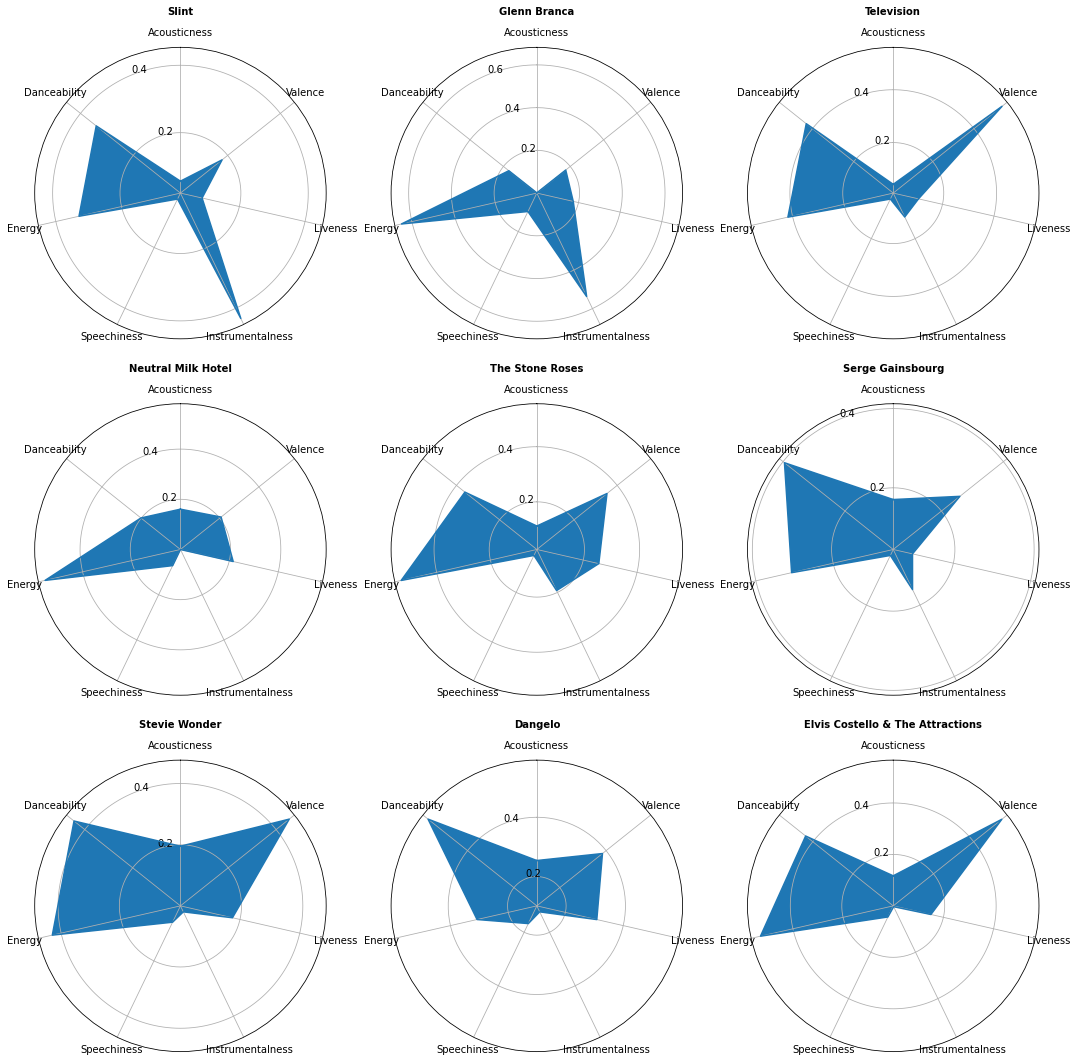

In [ ]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3, subplot_kw=dict(projection='radar'))

top_score = best_scores_df[['artist'] + features].head(9).values.tolist()

for i, ax in enumerate(axs.flat):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(top_score[i][0].title(), weight='bold', size='medium', position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')
        ax.plot(theta, top_score[i][1:])
        ax.fill(theta, top_score[i][1:])
        ax.set_varlabels(spoke_labels)

fig.tight_layout()
fig.show()

It is worth noticing that unlike Spotify, *the Pitchfork top artists do not have a singular common trait. Instead, there are a few artists with high danceability and/or energy such as Stevie Wonder, but there are also artists like Glenn Branca with low danceability and high instrumentalness, as well as artists like Slint that feature both.* This suggests that Pitchfork reviews a wider number of genres and varities of music than Spotify and might be more accepting of different types of music. What this means is that a song on Pitchfork might not necessarily be successful on Spotify and that simply making a song danceable and energetic might help boost popularity amongst listeners but will not necessarily get critical acclaim. 

Likewise, a critically acclaimed classical music album with high instrumentalness may not get listens on Spotify despite a high Pitchfork rating.

#**Prediction Problem**

Since we have data on albums from Pitchfork and songs from Spotify, we want to be able to predict which albums will perform well on Pitchfork in terms of critic score and sentiment, and which songs will perform well on Spotify based on popularity.

#**Data set creation**

We do this by setting up two distinct data frames, one for albums and the other for songs. We also create 3 different labels, one for the Pitchfork Score, one for sentiment score and one for spotify popularity. We intend on predicting these values using the various features available to us.

We plan on predicting Pitchfork Score and Sentiment on a per album basis, and Spotify popularity on a per song basis since this is how our original data was structured.

##Album data

Since our audio features are available on a per song basis, we do not, for example, have a danceability score for the entire album. Hence, we create predictors for album prediction by performing a group by and averaging continuous features amongst all the songs in each album and treating this as the predictor for the entire album.

We understand that this may not be perfectly accurate and we might be losing information in the process of averaging. For example, the variance and distribution of audio features on a given album might contribute positively or negatively to it's critical success if the critic finds the album particularly cohesive or scattered. However, this was the best way to get predictors for album data based on what data was available to us.

In [ ]:
# Drop non numeric and non predictive columns
df_album = df.drop(columns=['album_title', 'artist', 'song_title', 'sp_id', 'reviewid', 'title', 'author', 'author_type', 'review_content','pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year','acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence'])
# Perform Group by to get predictors on per album basis
df_album = df_album.groupby('album_id',as_index=False).mean()
# Drop Album Id because non predictive
df_album.drop(columns=['album_id'], inplace= True)
# Create 2 separate labels for Pitchfork Score and Sentiment Score
label_pitchfork = df_album['score']
label_sentiment = df_album['review_score']
# Create data frame full of predictors
df_album.drop(columns=['score', 'review_score'], inplace=True)
df_album.head()

duration_ms  explicit  ...  liveness_log  valence_log
0  340388.666667       0.0  ...      0.103298     0.302759
1  695543.500000       0.0  ...      0.249642     0.063784
2  250805.333333       0.0  ...      0.124438     0.358285
3  232981.200000       0.0  ...      0.304142     0.325368
4  158505.000000       0.0  ...      0.184330     0.417464

[5 rows x 16 columns]

##Song data

Since we had publishing weekday, day, month and year data available on a per song basis, we decided to use these as predictors and we did this using one hot encoding to ensure that we do not interpret these numerically.

In [ ]:
# Drop non numeric and non predictive columns
df_song = df.drop(columns=['album_title', 'artist', 'song_title', 'reviewid', 'title', 'author', 'author_type', 'review_content','pub_date','score', 'review_score', 'album_id', 'sp_id', 'acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence'])
# Perform One hot encoding
df_song_categorical = pd.get_dummies(df_song[['pub_weekday', 'pub_day', 'pub_month', 'pub_year']])
df_song_categorical.pub_weekday= df_song_categorical.pub_weekday.astype('category')
df_song_categorical.pub_day= df_song_categorical.pub_day.astype('category')
df_song_categorical.pub_month= df_song_categorical.pub_month.astype('category')
df_song_categorical.pub_year= df_song_categorical.pub_year.astype('category')
df_song_categorical = pd.get_dummies(df_song_categorical)

In [ ]:
df_song_continuous = df_song.drop(columns=['pub_weekday','pub_day', 'pub_month', 'pub_year'])
# Merge continuous and categorical data
df_song = pd.merge(df_song_continuous, df_song_categorical, left_index=True, right_index=True)

In [ ]:
# Create Spotify Popularity label
label_spotify = df_song['popularity']
# Create data frame of predictors
df_song.drop(columns=['popularity'], inplace=True)
df_song.head()

duration_ms  explicit  ...  pub_year_2016  pub_year_2017
0       330773         0  ...              0              1
1       379533         0  ...              0              1
3       366893         0  ...              0              1
4       251200         0  ...              0              1
5       357133         0  ...              0              1

[5 rows x 84 columns]

# **Regression for Association**

We begin by performing Regression to gain association insights into signficant features for prediction of the 3 different labels.

## Pitchfork Association

In [ ]:
import statsmodels.formula.api as smf

df_album['pitchfork_score'] = label_pitchfork

ols_pitchfork = smf.ols(formula = 'pitchfork_score ~ acousticness_log + danceability_log + energy_log + loudness_log + speechiness_log + instrumentalness_log + liveness_log+ valence_log + duration_ms +	explicit + popularity + key + mode + tempo +	time_signature', data = df_album)
res_ols_pitchfork = ols_pitchfork.fit()
print(res_ols_pitchfork.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:        pitchfork_score   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     40.35
Date:                Wed, 05 May 2021   Prob (F-statistic):          4.87e-116
Time:                        21:16:55   Log-Likelihood:                -18570.
No. Observations:               11367   AIC:                         3.717e+04
Df Residuals:                   11351   BIC:                         3.729e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.1174 

There are a lot of significant variables as seen in the multiple regression output. *Namely the log of: Acousticness, Danceability, Loudness, Speechiness, Instrumentalness, Valence are all significant at the 0.05 alpha level. With these, even Duration, popularity on spotify and mode are significant.* 

The interpretation of this association is clear from the values of the coefficients. Variables with positive coefficients such as Acousticeness and Speechiness imply that the performance on pitchfork improves if the song has a higher level of that attribute.

*Similarly negative coefficients such as those for Danceability and Loudness* imply that songs with higher levels of these perform worse on pitchfork (Get lower pitchfork reviews).

This makes sense with the Radar charts that we saw where artists who performed the best on picthfork had high levels of acousticness and low levels of danceability.

## Sentiment Analysis Association

In [ ]:
df_album['sentiment_score'] = label_sentiment
df_album.drop(columns=['pitchfork_score'],inplace=True)

ols_sentiment = smf.ols(formula = 'sentiment_score ~ acousticness_log + danceability_log + energy_log + loudness_log + speechiness_log + instrumentalness_log + liveness_log+ valence_log + duration_ms +	explicit + popularity + best_new_music + key + mode + tempo +	time_signature', data = df_album)
res_ols_sentiment = ols_sentiment.fit()
print(res_ols_sentiment.summary())
df_album.drop(columns=['sentiment_score'], inplace=True)


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     49.14
Date:                Wed, 05 May 2021   Prob (F-statistic):          1.58e-151
Time:                        21:16:55   Log-Likelihood:                -51028.
No. Observations:               11367   AIC:                         1.021e+05
Df Residuals:                   11350   BIC:                         1.022e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               29.3691 

Similar to the analysis above, we can check for significant variables in predicting sentiment. *The log of: Acousticeness, Danceability, Energy, Speechiness, Liveness, Valence are all significant at the alpha 0.05 level. Along with the log features: duration, explicit, popularity on spotify and mode are also signficant at the 0.05 alpha level.*

Some notable features and their coefficients are: danceability_log, speechiness_log and explicit.

*Danceability has a very high magnitude and positive coefficient* which implies that danceability boosts positive sentiment. At the same time *speechiness has a very high negative coefficient* which implies that having lyrics  causes negative sentiment amongst listeners. This makes sense, it is possible that those who do not resonate with lyrics write extremely negative reviews and this drops sentiment value. Finally *explicit also has a negative coefficient* implying that explicit songs have low sentiment scores and this also falls in line with our intuition.

## Spotify Predictions

In [ ]:
df_song['spotify_score'] = label_spotify

ols_spotify = smf.ols(formula = 'spotify_score ~ acousticness_log + danceability_log + energy_log + loudness_log + speechiness_log + instrumentalness_log + liveness_log+ valence_log + duration_ms +	explicit + best_new_music + key + mode + tempo +	time_signature', data = df_song)
res_ols_spotify = ols_spotify.fit()
print(res_ols_spotify.summary())
df_song.drop(columns=['spotify_score'], inplace=True)

                            OLS Regression Results                            
Dep. Variable:          spotify_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     981.2
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        21:16:55   Log-Likelihood:            -3.5042e+05
No. Observations:               86630   AIC:                         7.009e+05
Df Residuals:                   86614   BIC:                         7.010e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -17.8246 

*Barring energy_log and key, all other variables are significant with the spotify popularity.* This hints at potential multicollinearity and thus PCA is performed during prediction.

Some notable coefficients are: Acousticeness, Danceability and Explicit. This is because while Acousticeness helped in improving pitchfork reviews, on spotify Acousticeness reduces popularity (negative coefficient). Similarly, while danceability hurt songs in pitchfork, it improves popularity on spotify. Finally, explicit songs are likely to perform better on spotify, and this is also the opposite from picthfork.

## Conclusion from Regression Association

There are many features which are significant for all 3 label values. **There is a clear difference in songs that perform well on pitchfork versus spotify. Pitchfork prefers non explicit, acoustic songs with low danceability and energy while spotify listeners prefer the opposite.** This is a key insight for musicians who should think about what platform they want to try to suceed in. 

#**Tree for Association**

We also use decision trees and their visual capabilities as a way to find important features and compare these to the outputs of regression association.

##Pitchfork Association

             Feature  Importance
10      loudness_log       0.510
8   danceability_log       0.194
2         popularity       0.159
0        duration_ms       0.076
11   speechiness_log       0.061


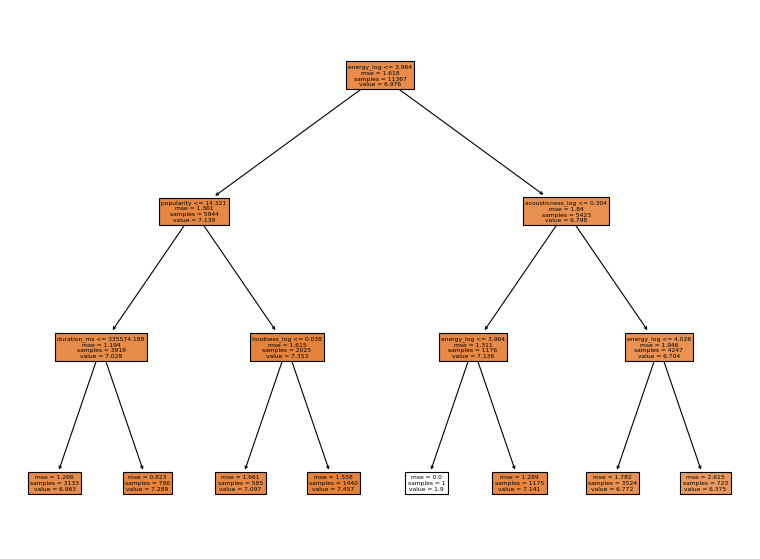

In [ ]:
from sklearn import tree

regtree = tree.DecisionTreeRegressor(max_depth=3, random_state=545)

regtree.fit(df_album.drop(columns=['best_new_music']), label_pitchfork)
fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
tree.plot_tree(regtree, filled=True, feature_names=df_album.columns);

pitchfork_importances = pd.DataFrame({'Feature':df_album.drop(columns=['best_new_music']).columns,'Importance':np.round(regtree.feature_importances_,3)})
pitchfork_importances = pitchfork_importances.sort_values('Importance',ascending=False)
print(pitchfork_importances[:5]) # Top five 


The decision tree output shows us that *songs with the best pitchfork ratings have low energy, high popularity, and high loudness.* 

*The variable importance analysis shows that Loudness, Danceability and Popularity on spotify are the most impotant predictors of how well a song on pitchfork will do.* 

Artists should focus on these metrics to improve their performance going forward.

##Sentiment Analysis Association

             Feature  Importance
12   speechiness_log       0.419
9   danceability_log       0.184
8   acousticness_log       0.170
1           explicit       0.094
3     best_new_music       0.076


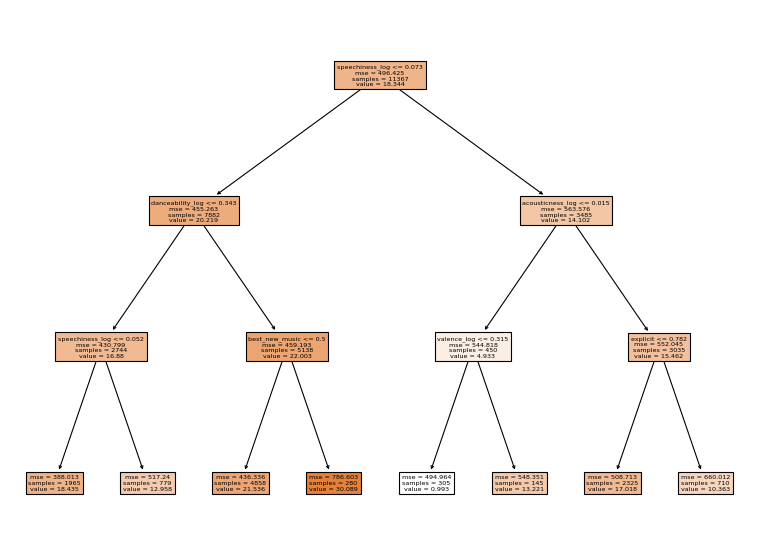

In [ ]:
regtree.fit(df_album, label_sentiment)
fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
tree.plot_tree(regtree, filled=True, feature_names=df_album.columns);

sentiment_importances = pd.DataFrame({'Feature':df_album.columns,'Importance':np.round(regtree.feature_importances_,3)})
sentiment_importances = sentiment_importances.sort_values('Importance',ascending=False)
print(sentiment_importances[:5]) # Top five 

*Songs with most positive sentiment have low speechiness, high danceability, and are part of best new music.* This makes sense and falls in line with the results from the regression.

*Songs with most negative sentiment have high speechiness, low acousticeness, and low valence.* This also coincides with results from regression association.

**The key insight from this is that EDM and non lyric songs that are very danceable have the most positive sentiment.**

##Spotify Association

                 Feature  Importance
1               explicit       0.477
2         best_new_music       0.343
12  instrumentalness_log       0.118
0            duration_ms       0.036
18         pub_weekday_3       0.017


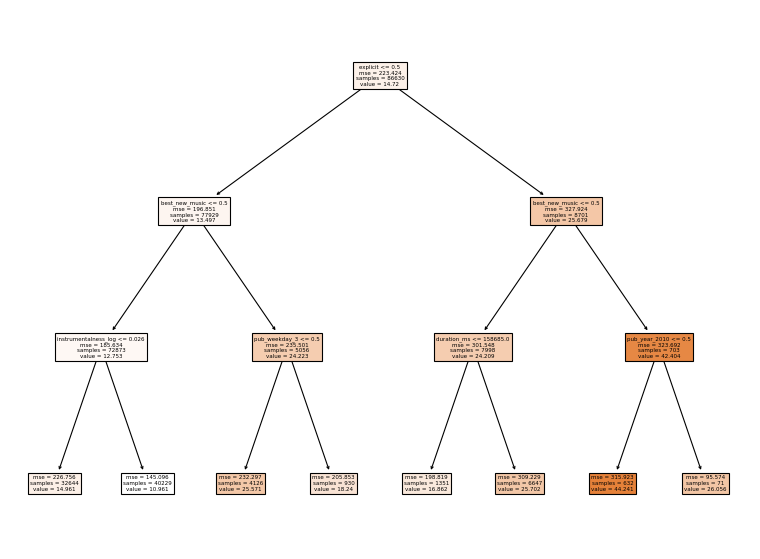

In [ ]:
regtree.fit(df_song, label_spotify)
fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
tree.plot_tree(regtree, filled=True, feature_names=df_song.columns);

spotify_importances = pd.DataFrame({'Feature':df_song.columns,'Importance':np.round(regtree.feature_importances_,3)})
spotify_importances = spotify_importances.sort_values('Importance',ascending=False)
print(spotify_importances[:5]) # Top five 

*Songs that are explicit, part of pitchfork's best new music, and which are not published in 2010 are the most popular on spotify.* This is interesting because this means that there is a possibility that pitchfork impacts spotify popularity. With every association problem, it is impossible to tell if correlation is causation, but this is something to look into. *We also hypothesize that 2010 might have been a very bad year for music* because the model predicts that songs that were not published in 2010 are likely to perform much better than those published in 2010.


*Non explicit songs, not part of best new music with high instrumentalness are the least popular on spotify.* These are not surprising considering all the analysis we have seen so far from the regression and the pitchfork data.

# **Continuous Problem**

The next thing we attempted was to predict the actual Pitchfork Score and Review Sentiment for each album and Spotify Popularity for each song. We did this using three different models - a linear regression, a random forest, and boosting. This made sense since our label in this case is continuous.

## Train Test Split

We now perform a 70/30 Train-Test split on both the album and song data frame. We also have 3 different y_train and y_test values, one for each label (Pitchfork Score, Sentiment Score and Spotify popularity).

###Album Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
pitchfork_x_train, pitchfork_x_test, pitchfork_y_train, pitchfork_y_test = train_test_split(df_album.drop(columns=['best_new_music']), label_pitchfork, test_size = 0.3, random_state = 545)
sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test = train_test_split(df_album, label_sentiment, test_size = 0.3, random_state = 545)

###Song Data

In [ ]:
spotify_x_train, spotify_x_test, spotify_y_train, spotify_y_test = train_test_split(df_song, label_spotify, test_size = 0.3, random_state = 545)

## Visualizing Multicolinearity

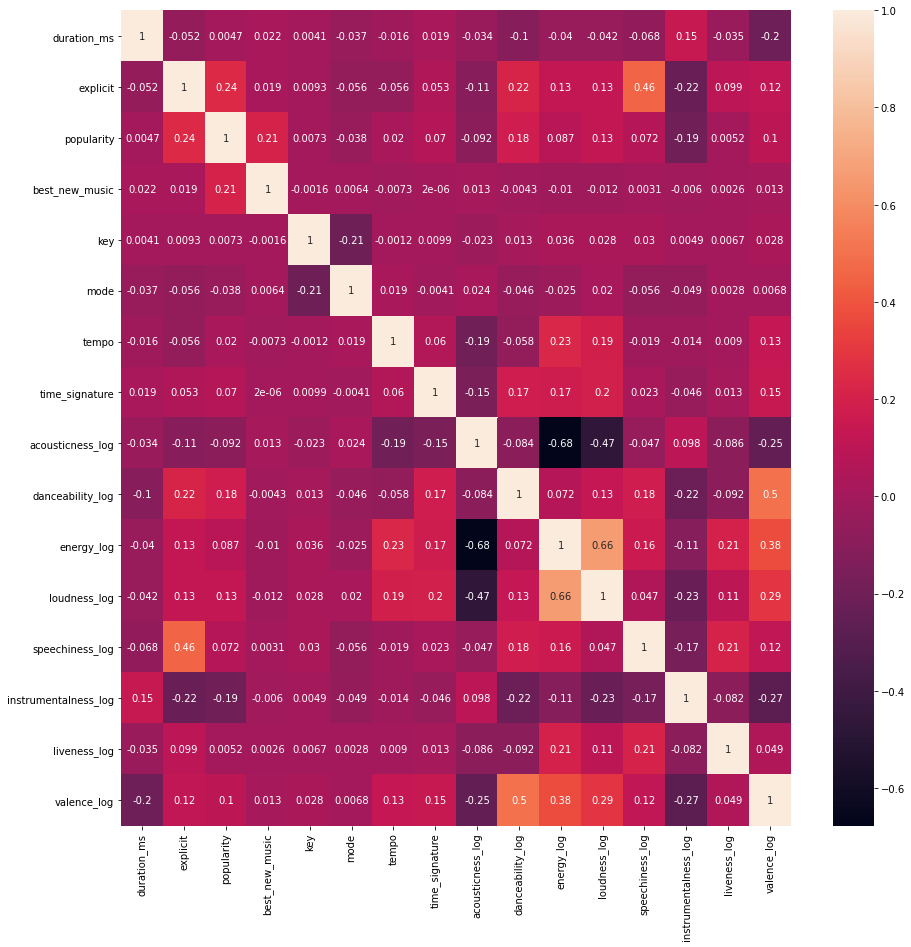

In [ ]:
corr = df_song_continuous.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)
plt.show()

We don't find very high correlation amongst the features in the corr plot. *Apart from Acousticeness which has a strong negative correlation with Energy and Loudness (-0.68 and -0.47) nothing seems to imply multi collinearity.* None the less, we decided that PCA cannot hurt the model, so we performed a PCA transformation before performing prediction on the data.

## PCA

We apply the transformation to all 3 training data sets:
Pitchfork, Sentiment and Spotify.

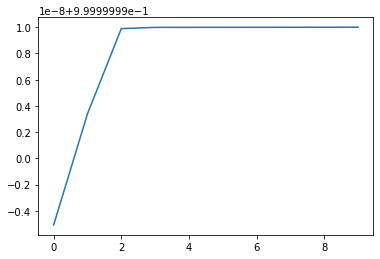

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

#Pitchfork
pitchfork_x_train_pca = pca.fit_transform(pitchfork_x_train)

np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)
plt.show()

pca_reduced = PCA(n_components = 5)
pca_reduced.fit(pitchfork_x_train)
pitchfork_x_train = pca_reduced.transform(pitchfork_x_train)

pitchfork_x_test = pca_reduced.transform(pitchfork_x_test)

The knee bend appears at around 2, but to be safe we select the components to be 5.

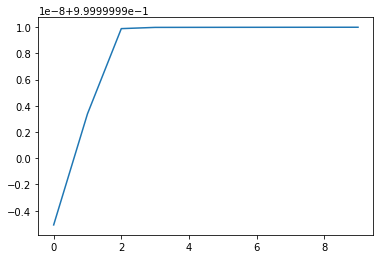

In [ ]:
#Sentiment
sentiment_x_train_pca = pca.fit_transform(sentiment_x_train)

np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance);
plt.show()

pca_reduced = PCA(n_components = 5)
pca_reduced.fit(sentiment_x_train)
sentiment_x_train = pca_reduced.transform(sentiment_x_train)

sentiment_x_test = pca_reduced.transform(sentiment_x_test)

The knee bend appears at around 2, but to be safe we select the components to be 5.

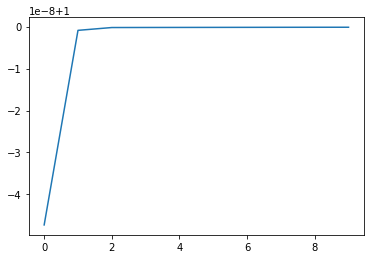

In [ ]:
#Spotify

spotify_x_train_pca = pca.fit_transform(spotify_x_train)

np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance);
plt.show()

pca_reduced = PCA(n_components = 5)
pca_reduced.fit(spotify_x_train)
spotify_x_train = pca_reduced.transform(spotify_x_train)

spotify_x_test = pca_reduced.transform(spotify_x_test)


The knee bend appears at around 2, but to be safe we select the components to be 5.

## Linear Regression

In [ ]:
#Imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Pitchfork Score Predictions

Train Score: 0.026370343772984084
Score: 0.024463394253840143


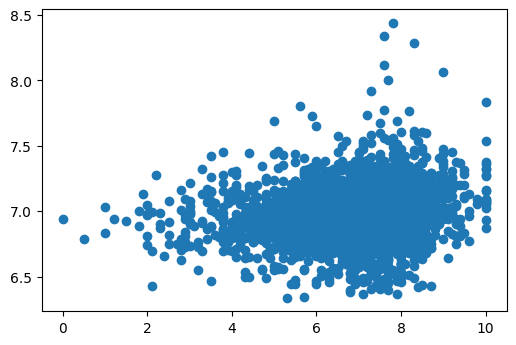

In [ ]:
# Instantiate and fit the model on pitchfork x and y train data
clf = LinearRegression()
clf.fit(pitchfork_x_train, pitchfork_y_train)
# Make Predictions on train and test
predictions = clf.predict(pitchfork_x_test)
train_predictions = clf.predict(pitchfork_x_train)
# Find the score for predictions in test data and plot predictions vs actual values
plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, predictions)

# Different error measures
print("Train Score:", r2_score(pitchfork_y_train, train_predictions))
print("Score:", r2_score(pitchfork_y_test, predictions))


We can see that our model was not particularly successful at determining the exact pitchfork score and only got a test score of ***2.45%***. To improve this, we tried the three different regularization methods - Lasso, Ridge, and Elastic Net.

Score: 0.0069285182061568085
Train Score: 0.006226369015824074


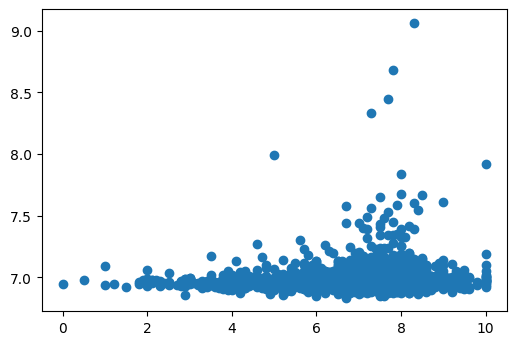

In [ ]:
#Instantiate and fit a lasso model on train data
clf = Lasso()
clf.fit(pitchfork_x_train, pitchfork_y_train)
#Make predictions for train and test data
predictions = clf.predict(pitchfork_x_test)
train_predictions = clf.predict(pitchfork_x_train)
#Find score for test data and plot predictions vs actual values
plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, predictions)

# Different error measures
print("Score:", r2_score(pitchfork_y_test, predictions))
print("Train Score:", r2_score(pitchfork_y_train, train_predictions)) 

We notice that Lasso Regularization actually reduced our score substantially on both, testing and training, down to ***0.6%***. This makes sense because in our unpenalised regression we have a very low training score, and this implies underfitting of the data. Penalising will only make this worse and that is why lasso underperforms.

Train Score: 0.02637030940383633
Score: 0.02446861201620232


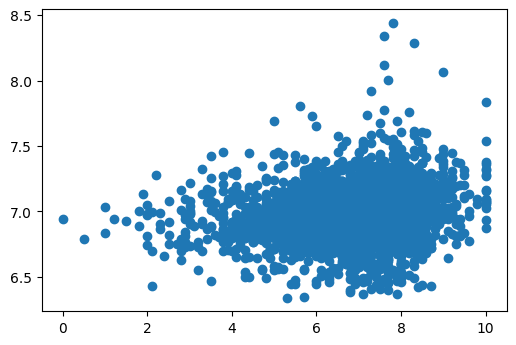

In [ ]:
clf = Ridge()
clf.fit(pitchfork_x_train, pitchfork_y_train)

predictions = clf.predict(pitchfork_x_test)
train_predictions = clf.predict(pitchfork_x_train)

plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, predictions)

# Different error measures
print("Train Score:", clf.score(pitchfork_x_train, pitchfork_y_train))
print("Score:", clf.score(pitchfork_x_test, pitchfork_y_test))

Our ridge score is identical to the score from unpenalised regression, which is another indicator of underfitting. The ridge has no reason to penalise the coefficients and therefore the result is the same.

0.2
Train Score: 0.010206750103492921
Score: 0.012027986550138259


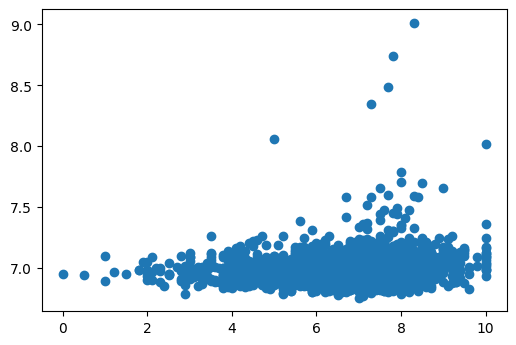

In [ ]:
from sklearn.model_selection import GridSearchCV

L1_ratio = [0.2, 0.4, 0.6, 0.8]
clf = ElasticNet()

GS_object = GridSearchCV(estimator=clf, param_grid={'l1_ratio': L1_ratio})
GS_object.fit(pitchfork_x_train, pitchfork_y_train)

print(GS_object.best_params_['l1_ratio'])

clf = ElasticNet(l1_ratio=GS_object.best_params_['l1_ratio'])

clf.fit(pitchfork_x_train, pitchfork_y_train)

predictions = clf.predict(pitchfork_x_test)
train_predictions = clf.predict(pitchfork_x_train)

plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, predictions)

# Different error measures

print("Train Score:", clf.score(pitchfork_x_train, pitchfork_y_train))
print("Score:", clf.score(pitchfork_x_test, pitchfork_y_test))

For elastic net, we chose 3 different alpha values: 0.2, 0.4, 0.6, and 0.8. We performed cross validation to find the best alpha value. This turned out to be 0.2, which gave a test score of ***1.2%***. There is still clear underfitting on train data, and the model performs quite poorly.

The best result was for Unpenalised regression which was the same as ridge at ***2.45%***.

### Sentiment Analysis Predictions

Train Score: 0.013435202534487822
Score: 0.013135726084642751


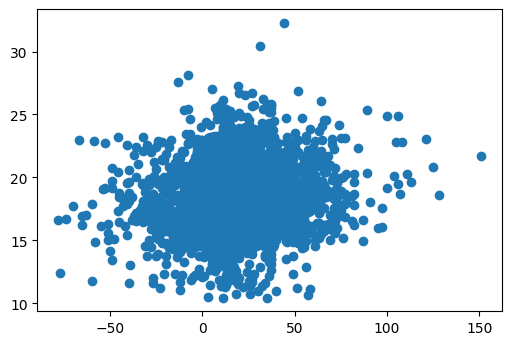

In [ ]:
clf = LinearRegression()
clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test)
train_predictions = clf.predict(sentiment_x_train)

plt.figure(dpi=100)
plt.scatter(sentiment_y_test, predictions)

# Different error measures

print("Train Score:", clf.score(sentiment_x_train, sentiment_y_train))
print("Score:", clf.score(sentiment_x_test, sentiment_y_test))

We can see that our model was not particularly successful, similar to pitchfork, at determining the exact sentiment score and only got a test score of ***1.31%***. Once again, we tried the three different regularization methods - Lasso, Ridge, and Elastic Net.



Train Score: 0.006439824369424363
Score: 0.0005454288020458886


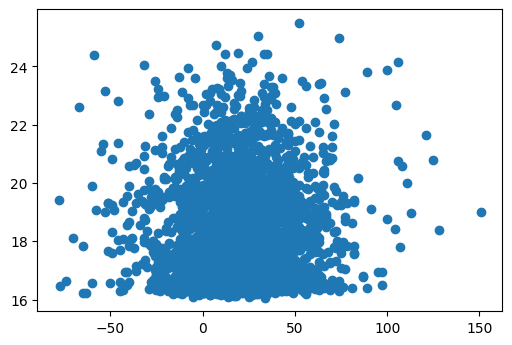

In [ ]:
clf = Lasso()
clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test)
train_predictions = clf.predict(sentiment_x_train)

plt.figure(dpi=100)
plt.scatter(sentiment_y_test, predictions)

# Different error measures

print("Train Score:", clf.score(sentiment_x_train, sentiment_y_train))
print("Score:", clf.score(sentiment_x_test, sentiment_y_test))

We notice that Lasso Regularization again reduced our score substantially on both, testing and training, down to ***0.6%*** and ***0.05%***. This makes sense because in our unpenalised regression we have a very low training score, and this implies underfitting of the data. Penalising will only make this worse and that is why lasso underperforms.

Train Score: 0.013435187916328362
Score: 0.013128790388315048


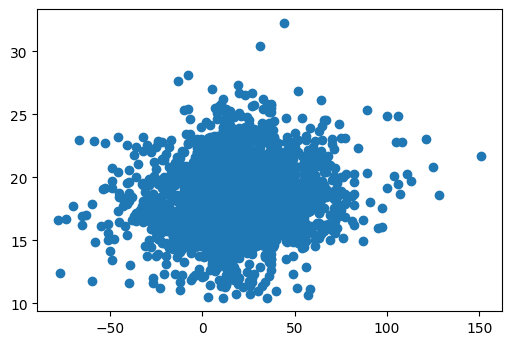

In [ ]:
clf = Ridge()
clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test)
train_predictions = clf.predict(sentiment_x_train)


plt.figure(dpi=100)
plt.scatter(sentiment_y_test, predictions)

# Different error measures
print("Train Score:", clf.score(sentiment_x_train, sentiment_y_train))
print("Score:", clf.score(sentiment_x_test, sentiment_y_test))

Our ridge score is identical to the score from unpenalised regression, which is another indicator of underfitting. The ridge has no reason to penalise the coefficients and therefore the result is the same.

0.2
Train Score: 0.007354999257053518
Score: 0.002212043488355353


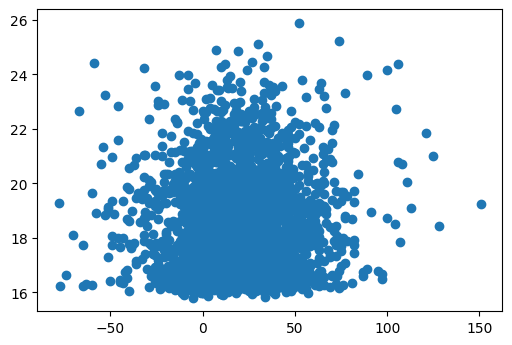

In [ ]:
L1_ratio = [0.2, 0.4, 0.6, 0.8]
clf = ElasticNet()

GS_object = GridSearchCV(estimator=clf, param_grid={'l1_ratio': L1_ratio})
GS_object.fit(sentiment_x_train, sentiment_y_train)

print(GS_object.best_params_['l1_ratio'])

clf = ElasticNet(l1_ratio=GS_object.best_params_['l1_ratio'])

clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test)
train_predictions = clf.predict(sentiment_x_train)

plt.figure(dpi=100)
plt.scatter(sentiment_y_test, predictions)

# Different error measures

print("Train Score:", clf.score(sentiment_x_train, sentiment_y_train))
print("Score:", clf.score(sentiment_x_test, sentiment_y_test))

For elastic net, we chose 3 different alpha values: 0.2, 0.4, 0.6, and 0.8. We performed cross validation to find the best alpha value. This turned out to be 0.2, which gave a test score of ***0.2%***. There is still clear underfitting on train data, and the model performs quite poorly.

The best result was for Unpenalised regression which was ***1.3%***.

### Spotify Popularity Predictions

Train Score: 0.01032982376986391
Score: 0.01073340283567814


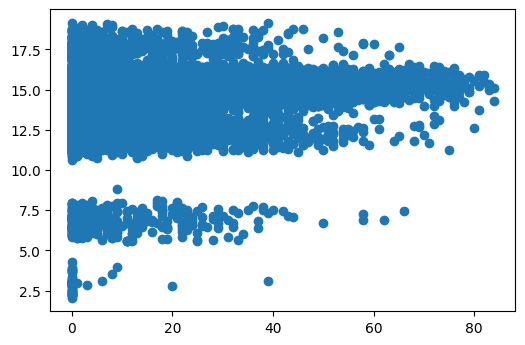

In [ ]:
clf = LinearRegression()
clf.fit(spotify_x_train, spotify_y_train)

predictions = clf.predict(spotify_x_test)
train_predictions = clf.predict(spotify_x_train)

plt.figure(dpi=100)
plt.scatter(spotify_y_test, predictions)

# Different error measures
print("Train Score:", clf.score(spotify_x_train, spotify_y_train))
print("Score:", clf.score(spotify_x_test, spotify_y_test))

We can see that our model was not particularly successful, similar to pitchfork and sentiment, at determining the exact spotify popularity and only got a test score of ***1.07%***. Once again, we tried the three different regularization methods - Lasso, Ridge, and Elastic Net.

Train Score: 0.0005366461350509999
Score: 0.0001097079067094997


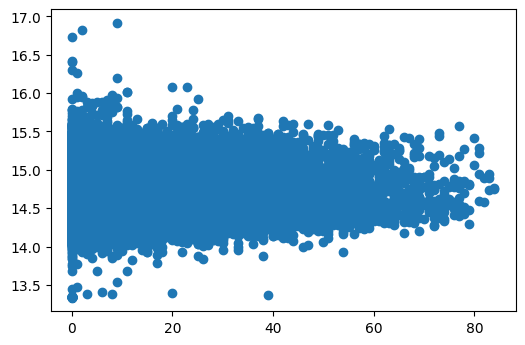

In [ ]:
clf = Lasso()
clf.fit(spotify_x_train, spotify_y_train)

predictions = clf.predict(spotify_x_test)
train_predictions = clf.predict(spotify_x_train)

plt.figure(dpi=100)
plt.scatter(spotify_y_test, predictions)

# Different error measures

print("Train Score:", clf.score(spotify_x_train, spotify_y_train))
print("Score:", clf.score(spotify_x_test, spotify_y_test))

We notice that Lasso Regularization again reduced our score substantially on both, testing and training, down to ***0%*** (offering no predictive ability). This makes sense because in our unpenalised regression we have a very low training score, and this implies underfitting of the data. Penalising will only make this worse and that is why lasso doesn't perform at all. It doesn't have any features to work with at all. This may also be because PCA was performed.

Score: 0.010733343194591849
Train Score: 0.01032982373009905


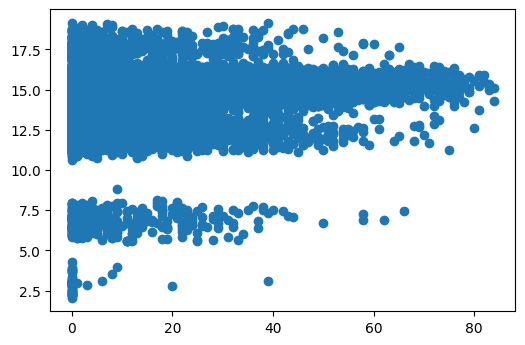

In [ ]:
clf = Ridge()
clf.fit(spotify_x_train, spotify_y_train)

predictions = clf.predict(spotify_x_test)
train_predictions = clf.predict(spotify_x_train)

plt.figure(dpi=100)
plt.scatter(spotify_y_test, predictions)

# Different error measures
print("Score:", clf.score(spotify_x_test, spotify_y_test))
print("Train Score:", clf.score(spotify_x_train, spotify_y_train))


Our ridge score is identical to the score from unpenalised regression, which is another indicator of underfitting. The ridge has no reason to penalise the coefficients and therefore the result is the same.

0.2
Score: 0.0020310595763306516
Train Score: 0.002364249006541863


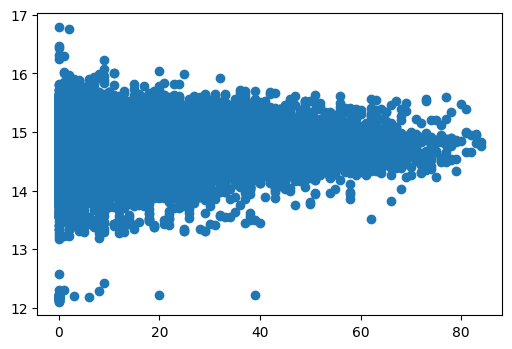

In [ ]:
L1_ratio = [0.2, 0.4, 0.6, 0.8]
clf = ElasticNet()

GS_object = GridSearchCV(estimator=clf, param_grid={'l1_ratio': L1_ratio})
GS_object.fit(spotify_x_train, spotify_y_train)

print(GS_object.best_params_['l1_ratio'])

clf = ElasticNet(l1_ratio=GS_object.best_params_['l1_ratio'])

clf = ElasticNet()
clf.fit(spotify_x_train, spotify_y_train)

predictions = clf.predict(spotify_x_test)
train_predictions = clf.predict(spotify_x_train)

plt.figure(dpi=100)
plt.scatter(spotify_y_test, predictions)

# Different error measures
print("Score:", clf.score(spotify_x_test, spotify_y_test))
print("Train Score:", clf.score(spotify_x_train, spotify_y_train))


For elastic net, we chose 3 different alpha values: 0.2, 0.4, 0.6, and 0.8. We performed cross validation to find the best alpha value. This turned out to be 0.2, which gave a test score of ***0.2%***. There is still clear underfitting on train data, and the model performs quite poorly.

The best result was for Unpenalised regression which was the same as ridge at ***1.07%***.

**Overall, regression was a very poor predictor for all 3 labels. We hypothesize that this is because the data is not linear in nature, so tree methods are expected to capture non linear variation better.**

##Random Forest

Here, we used a random forest regressor model on each of our datasets. We used the grid search object to tune the max-depth hyperparameter for our random forest regressor. 

We chose n_estimators from our intuition developed in past homeworks.

### Pitchfork Score Predictions

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

depth = [5, 6, 7]
nEstimator = 140

clf = RandomForestRegressor(n_estimators=nEstimator, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(pitchfork_x_train, pitchfork_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=545,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_

We found the best max depth to be 5

In [ ]:
GS_object.best_params_['max_depth']

5

Train Score: 0.08595509743756569
Score: 0.030430417007182298


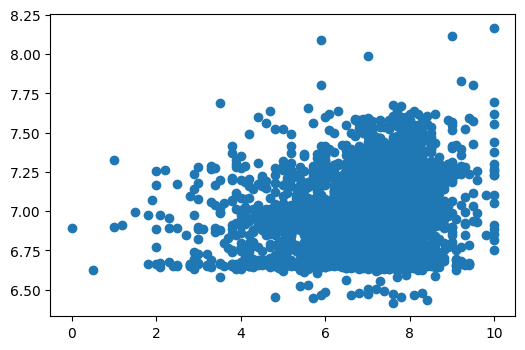

In [ ]:
n_estimators = 140
clf = RandomForestRegressor(n_estimators=nEstimator, max_depth=GS_object.best_params_['max_depth'], random_state=545)

clf.fit(pitchfork_x_train, pitchfork_y_train)
y_pred = clf.predict(pitchfork_x_test) 

plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, y_pred)

# Different error measures
print("Train Score:", clf.score(pitchfork_x_train, pitchfork_y_train))
print("Score:", clf.score(pitchfork_x_test, pitchfork_y_test))

*The random forest has a better train and test score compared to regression for pitchfork*. The train score is ***8.6%*** while the test score is ***3.04%***. *There is definite overfitting in the sense that test score is less than train score*, but we also find that *the train score is very poor.* This is weird because we are cross validating for max depth and the cross validation is predicting a low max depth, so the expectation is that a low complexity model will work in this data, but clearly that is not the case.


### Sentiment Analysis Predictions

In [ ]:
depth = [6, 7, 8]
nEstimator = 140

clf = RandomForestRegressor(n_estimators=nEstimator, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(sentiment_x_train, sentiment_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=545,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_

In [ ]:
GS_object.best_params_['max_depth']

7

Score: 0.019355757577812605
Train Score: 0.11850352638208084


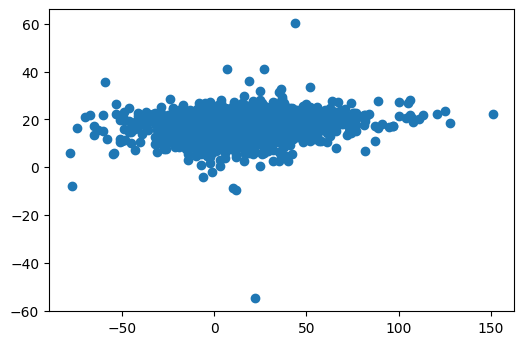

In [ ]:
n_estimators = 140
clf = RandomForestRegressor(n_estimators=nEstimator, max_depth=GS_object.best_params_['max_depth'], random_state=545)

clf.fit(sentiment_x_train, sentiment_y_train)
y_pred = clf.predict(sentiment_x_test) 

plt.figure(dpi=100)
plt.scatter(sentiment_y_test, y_pred)

# Different error measures

print("Score:", clf.score(sentiment_x_test, sentiment_y_test))
print("Train Score:", clf.score(sentiment_x_train, sentiment_y_train))

The model has a train of score ***11.8%*** and a test score of ***1.93%*** despite cross validating for max_depth. *This means we are again overfitting the data.* We do however find this test score to be better than regression which was 1.3%. It is still very marginal improvement.

### Spotify Predictions

In [ ]:
depth = [9, 10, 11]
nEstimator = 140
clf = RandomForestRegressor(n_estimators=nEstimator, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(spotify_x_train, spotify_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=545,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_

In [ ]:
GS_object.best_params_['max_depth']

10

Train Score: 0.18013049731224703
Score: 0.09808699046701465


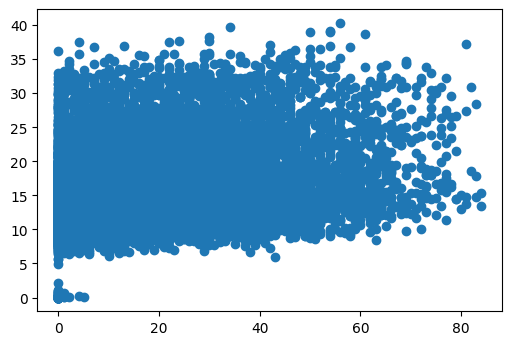

In [ ]:
n_estimators = 140
clf = RandomForestRegressor(n_estimators=nEstimator, max_depth=GS_object.best_params_['max_depth'], random_state=545)

clf.fit(spotify_x_train, spotify_y_train)
y_pred = clf.predict(spotify_x_test) 

plt.figure(dpi=100)
plt.scatter(spotify_y_test, y_pred)

# Different error measures

print("Train Score:", clf.score(spotify_x_train, spotify_y_train))
print("Score:", clf.score(spotify_x_test, spotify_y_test))

*We find that there is yet again overfitting*: the train score is ***18%*** while the test score is ***10%***, however this is a drastic improvement from linear regression.

##Boosting

###Pitchfork Score Predictions

We perform boosting using the AdaBoostRegressor. We experienced the problem of underfitting previously so we decided to change the base estimator from the default to a tree with depth 6. This would make the model more complex and thus help in fitting the training data better. We chose the number of estimators and learning rate arbitrarily low but using insights from past homeworks. 

Train Score: 0.07502668705774873
Score: 0.03078056480281144


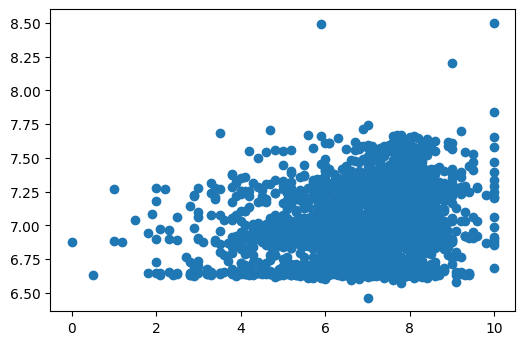

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth = 6, random_state = 545)

regr = AdaBoostRegressor(base_estimator = regressor, n_estimators=500, random_state = 545, learning_rate = 0.0001)
regr.fit(pitchfork_x_train, pitchfork_y_train)

predictions = regr.predict(pitchfork_x_test)
train_predictions = regr.predict(pitchfork_x_train)


plt.figure(dpi=100)
plt.scatter(pitchfork_y_test, predictions)

# Different error measures

print("Train Score:", regr.score(pitchfork_x_train, pitchfork_y_train))
print("Score:", regr.score(pitchfork_x_test, pitchfork_y_test))

*We find the issue of overfitting here* because the train score is ***7.5%*** which is higher than ***3.07%*** which is the test score. The model is very slightly better than random forest at predicting pitchfork scores, but it's still very poor.

###Sentiment Analysis Predictions

Similar to Pitchfork, we experienced the problem of underfitting previously so we decided to change the base estimator from the default to a tree with depth 6. This would make the model more complex and thus help in fitting the training data better. We chose the number of estimators and learning rate arbitrarily but using insights from past homeworks.

Train Score: 0.26171265162323243
Score: 0.014576809449418637


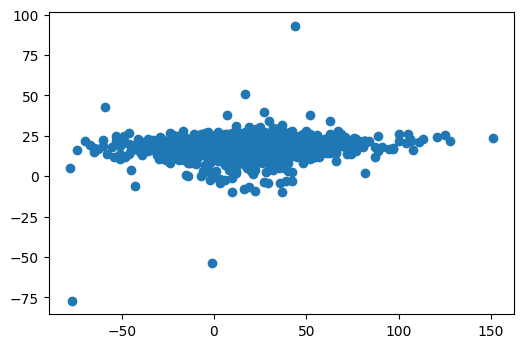

In [ ]:
regressor = DecisionTreeRegressor(max_depth = 13, random_state = 545)

regr = AdaBoostRegressor(base_estimator = regressor, n_estimators=500, random_state = 545, learning_rate = 0.0001)
regr.fit(sentiment_x_train, sentiment_y_train)

predictions = regr.predict(sentiment_x_test)
train_predictions = regr.predict(sentiment_x_train)


plt.figure(dpi=100)
plt.scatter(sentiment_y_test, predictions)

# Different error measures
print("Train Score:", regr.score(sentiment_x_train, sentiment_y_train))
print("Score:", regr.score(sentiment_x_test, sentiment_y_test))

*Boosting, just like random forest has over fitted the data.* The train score is high at ***26%*** while the test score is ***1.45%***. This test score is lower than the random forest test score of 1.93%. But this is a marginal difference.

###Spotify Popularity Predictions


Train Score: 0.11320375385238424
Score: 0.09473793076692293


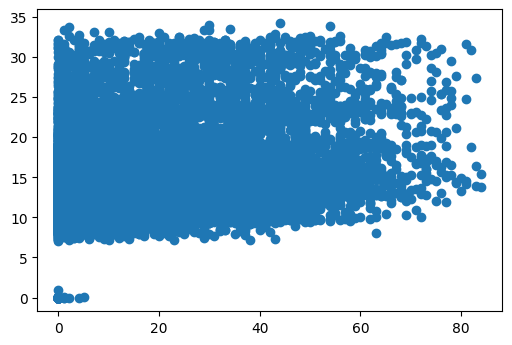

In [ ]:
regressor = DecisionTreeRegressor(max_depth = 8, random_state = 545)

regr = AdaBoostRegressor(base_estimator = regressor, n_estimators=500, random_state = 545, learning_rate = 0.0001)
regr.fit(spotify_x_train, spotify_y_train)


predictions = regr.predict(spotify_x_test)
train_predictions = regr.predict(spotify_x_train)


plt.figure(dpi=100)
plt.scatter(spotify_y_test, predictions)

# Different error measures

print("Train Score:", regr.score(spotify_x_train, spotify_y_train))
print("Score:", regr.score(spotify_x_test, spotify_y_test))

There is not much overfitting in this model (the train and test score are very close: ***11% and 9.4%***). This is slightly worse than random forest which had a test score of 10%.

##Conclusion of continuous problem

**In summary, we found that the Pitchfork scores were best predicted by Boosting, which had a test score of 3.07%. For Sentiment Analysis, we found that the Random Forest achieves the higest accuracy, with a test score of 1.93%. Finally, for Spotify Popularity, we found that Random Forest achieves the best score, with a test score of 10%.**
 
*In general the Random Forest and Boosting had very similar test scores showing that they are very similar and proving our initial hypothesis that the data is not linear so non linear prediction will out perform prediction.* 

There are a few important observations we can make. *First, we realize that Regression is never the best model to use for continuous prediction.* This makes sense because we are performing a linear regression on data that is likely non linear. 

Further, we can see that scores across the board are quite low. This can be for three reasons:

**1. The features available to us are just bad predictors of pitchfork score, sentiment and spotify popularity. Since prediction is a complicated task and depends heavily on the actual features, it is possible that the data available is just not good at predicting the labels so we have to consider different features and try this again. This is most clear with Spotify data, wherein the predictors available to us may not be good indicators of a song's success since Spotify popularity may not be based as much on actual audio atttributes and might be based on things such as artist popularity, global trends in music, and word of mouth.**

**2. We are not cross validating for every parameter. Prediction is a task with infinite possibilities of improvement and improvement occurs through cross validation of parameters. Signs of overfitting are observed and this can be limited by further tuning parameters such as max depth, max features, etc. We did not have enough time or computing power to efficiently perform such a task and therefore our results are not great.**

**3. Lastly, the act of scoring an album on pitchfork is not inherently continuous, since critics are human beings that are likely to think of albums in qualitative terms and assign a rating relatively arbitrarily. The model aims to predict the exact score but in reality, these are somewhat random since critics may not have a meaningful quantifiable reason why a particular album is a 7.5 instead of a 7.3. Likewise, a critic's choice of words is often arbitrary and the sentiment analysis might draw a difference between "fantastic" and "spectacular," for example, which the critic may see as equally positive.**

  **We also notice that we are seeing overfitting throughout, which makes sense since the data inherently has high variability (because of the reasons explained above) and so the model will end up capturing noise that may not be the same in test data.**


# **Classification Problem**

Considering the possibility of the 3rd case, as described above, we realise that we can alleviate the problem by treating this as a classification problem. 

*Artists do not care about the exact score they recieve on Pitchfork or the exact popularity statistic they recieve on Spotify. They care about being bucketed as an artist with positive sentiment songs or with chart buster popularity, or critical acclaim.*

By treating this as a classification problem, we will be able to achieve this analysis, and get rid of the issue of arbitrariness in pitchfork review scores and comments. Now an album with a 7.3 and 7.5 will be part of the same bucket which makes more intuitive sense in the prediction problem as well as in general when evaluating the importance of the prediction.

In this section we repeat the prediction problem using Logistic Regression, Random Forests and Boosting

## Data Set Creation

We decided to divide the pitchfork score, sentiment score and spotify popularity into categories instead of having them as continuous. 

Since some of the label data was skewed, we did not want class imbalance during our prediction problem so we used the python pd.qcut function to get relatively equal sized buckets.

For pitchfork score we broke the label into 3 categories: ***Outstanding, Average, and Underwhelming***.  Interestingly the data broke down well, because the best category had a score requirement of greater than 7.6 and pitchfork labels a song in best new music only if it has a rating of greater than 8. In general albums that are not outstanding are generally either average or bad hence 3 categories made sense.

For sentiment we decided it was best to just predict if an album ***had positive or negative sentiment***. Therefore we split this into 2 categories and based it off whether the album had a sentiment score of positive or negative. This makes sense because while it is easy to classify sentiment as positive or negative, the degree of positivity or negativity can be largely arbitrary and dependent on the choice of words so having more than 2 categories does not make sense.

For Spotify we decided that 4 was the best number of cuts to encompass the variability in the data. The labels split into: ***Chart Buster, Popular, Niche and Unheard*** which makes sense since these broadly encompass the 4 degrees of popularity a song might achieve.

In [ ]:
class_label_pitchfork = pd.qcut(label_pitchfork, 3)

def pitchfork_transform(x):
  if x == pd.Interval(7.6, 10.0, closed = 'right'):
    return 'Outstanding'
  elif x == pd.Interval(6.8, 7.6, closed = 'right'):
    return 'Average'
  else:
    return 'Underwhelming'
  
class_label_pitchfork = class_label_pitchfork.apply(pitchfork_transform)
class_label_pitchfork

0          Outstanding
1          Outstanding
2              Average
3          Outstanding
4              Average
             ...      
11362          Average
11363      Outstanding
11364      Outstanding
11365    Underwhelming
11366      Outstanding
Name: score, Length: 11367, dtype: category
Categories (3, object): ['Underwhelming' < 'Average' < 'Outstanding']

In [ ]:
class_label_sentiment = label_sentiment > 0

def sentiment_transform(x):
  if x == True:
    return 'Positive'
  else:
    return 'Negative'

class_label_sentiment = class_label_sentiment.apply(sentiment_transform)    
class_label_sentiment

0        Negative
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
11362    Negative
11363    Negative
11364    Positive
11365    Positive
11366    Positive
Name: review_score, Length: 11367, dtype: object

In [ ]:
class_label_spotify = pd.qcut(label_spotify, 4)
class_label_spotify

0         (23.0, 88.0]
1         (23.0, 88.0]
3         (23.0, 88.0]
4         (23.0, 88.0]
5         (23.0, 88.0]
              ...     
136594    (23.0, 88.0]
136597    (23.0, 88.0]
136599    (23.0, 88.0]
136600    (23.0, 88.0]
136603    (23.0, 88.0]
Name: popularity, Length: 86630, dtype: category
Categories (4, interval[float64]): [(-0.001, 3.0] < (3.0, 10.0] < (10.0, 23.0] < (23.0, 88.0]]

In [ ]:
class_label_spotify = pd.qcut(label_spotify, 4)
class_label_spotify

def spotify_transform(x):
  if x == pd.Interval(23.0, 88.0, closed = 'right'):
    return 'Chart Buster'
  elif x == pd.Interval(10.0, 23.0, closed = 'right'):
    return 'Popular'
  elif x == pd.Interval(3.0, 10.0, closed = 'right'):
    return 'Niche'
  else:
    return 'Unknown'
    
class_label_spotify = class_label_spotify.apply(spotify_transform)    
class_label_spotify

0         Chart Buster
1         Chart Buster
3         Chart Buster
4         Chart Buster
5         Chart Buster
              ...     
136594    Chart Buster
136597    Chart Buster
136599    Chart Buster
136600    Chart Buster
136603    Chart Buster
Name: popularity, Length: 86630, dtype: category
Categories (4, object): ['Unknown' < 'Niche' < 'Popular' < 'Chart Buster']

In [ ]:
print(class_label_pitchfork.value_counts())
print(class_label_sentiment.value_counts())
print(class_label_spotify.value_counts())


Underwhelming    3827
Average          3791
Outstanding      3749
Name: score, dtype: int64
Positive    9288
Negative    2079
Name: review_score, dtype: int64
Unknown         25445
Popular         21522
Chart Buster    20748
Niche           18915
Name: popularity, dtype: int64


## Train Test Split

Like in the continuos case, we perform a 70/30 Train/Test split on the data.

###Album Data

In [ ]:
pitchfork_x_train, pitchfork_x_test, pitchfork_y_train, pitchfork_y_test = train_test_split(df_album.drop(columns=['best_new_music']), class_label_pitchfork, test_size = 0.3, random_state = 545)
sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test = train_test_split(df_album, class_label_sentiment, test_size = 0.3, random_state = 545)

###Song Data

In [ ]:
spotify_x_train, spotify_x_test, spotify_y_train, spotify_y_test = train_test_split(df_song, class_label_spotify, test_size = 0.3, random_state = 545)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics


### Pitchfork Score Predictions

In [ ]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(pitchfork_x_train, pitchfork_y_train)

train_predictions = clf.predict(pitchfork_x_train)
predictions = clf.predict(pitchfork_x_test)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, pitchfork_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, pitchfork_y_test))

Train Accuracy: 0.3288084464555053
Test Accuracy: 0.33216065669891526


*The Logistic Regression faces underfitting* as seen from the low train accuracy and marginally higher test accuracy (***32% and 33%***) but one thing to note is that the model performs much better than the Linear regression which had a score of 2%.

*We know that underfitting is a function of lack of complexity and features, so we realise that penalising will only make this worse, therefore we avoid using penalised regression methods.*

### Sentiment Analysis Predictions

In [ ]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(sentiment_x_train, sentiment_y_train)

train_predictions = clf.predict(sentiment_x_train)
predictions = clf.predict(sentiment_x_test)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, sentiment_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, sentiment_y_test))

Train Accuracy: 0.8147310206133735
Test Accuracy: 0.8226326590442685


*We find that the classification problem for sentiment analysis performs very well* recieveing a train score of ***80%*** and test score of ***82%***. *There is still some underfitting on train data, but the over all classification accuracy is quite high*, which means that the model successfully predicts if an album will have positive or negative sentiment assoiciated with it based on the features available to us.

Again, underfitting implies that penalised regression will only make the score worse, none the less, we attempt elastic net with various values (mimicking ridge and lasso in the process) and this proves our hypothesis.

In [ ]:
L1_ratio = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

clf = LogisticRegression(max_iter=10000)

GS_object = GridSearchCV(estimator=clf, param_grid={'l1_ratio': L1_ratio})
GS_object.fit(sentiment_x_train, sentiment_y_train)

print(GS_object.best_params_['l1_ratio'])

clf = LogisticRegression(l1_ratio=GS_object.best_params_['l1_ratio'])

clf.fit(sentiment_x_train, sentiment_y_train)

train_predictions = clf.predict(sentiment_x_train)
predictions = clf.predict(sentiment_x_test)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, sentiment_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, sentiment_y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (p

0.0
Train Accuracy: 0.8147310206133735
Test Accuracy: 0.8226326590442685


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


We perform elastic net and cross validate for the best alpha value which is 0. This implies that ridge regression is used and the fact that the accuracy scores are exactly the same implies that the ridge model performs no penalisation (in line with our hypothesis regarding underfitting).

### Spotify Popularity Predictions

In [ ]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(spotify_x_train, spotify_y_train)

train_predictions = clf.predict(spotify_x_train)
predictions = clf.predict(spotify_x_test)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, spotify_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, spotify_y_test))

Train Accuracy: 0.2922775020200854
Test Accuracy: 0.2970872292123591


Spotify prediction get's a score of ***29%*** for train and ***30%*** for test. *This is again underfitting slightly*, but note that the score is a drastic improvement from the linear regression score which was 1%. Because of underfitting we avoid penalised regression, knowing that it will return the same or a worse output.

##Random Forest

For all our random forests, we had intuition from the continuous problem that the model experiences overfitting, so we ended up using max features as 4 so that we can ensure the model is not too complex and doesn't overfit the noise. We understand that this selection is arbitrary, and in reality we should use cross validation to select this parameter, but the lack of computing power disabled us from performing this quickly enough.

### Pitchfork Score Predictions

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

depth = [7, 8, 9]
nEstimator = 500

clf = RandomForestClassifier(n_estimators=nEstimator, max_features = 4, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(pitchfork_x_train, pitchfork_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=4,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False, random_state=545,
                                   

In [ ]:
GS_object.best_params_['max_depth']

8

In [ ]:
n_estimators = 500
clf = RandomForestClassifier(n_estimators=nEstimator, max_features = 4, max_depth=GS_object.best_params_['max_depth'])

clf.fit(pitchfork_x_train, pitchfork_y_train)

predictions = clf.predict(pitchfork_x_test)
train_predictions= clf.predict(pitchfork_x_train) 

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, pitchfork_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, pitchfork_y_test))

Train Accuracy: 0.6635243841126194
Test Accuracy: 0.43476986221049546


*The random forest for pitchfork experiences overfitting*, the train accuracy is a lot better than the test accuracy (***66% and 44%***). We notice that this however is a drastic improvement from the 33% classification score from logistic regression.

Despite cross validating on the max depth the model experiences overfitting, so this means tuning of more parameters is needed.

### Sentiment Analysis Predictions

In [ ]:
depth = [12, 13, 14]
nEstimator = 500

clf = RandomForestClassifier(n_estimators=nEstimator, max_features = 4, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(sentiment_x_train, sentiment_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=4,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False, random_state=545,
                                   

In [ ]:
GS_object.best_params_['max_depth']

12

In [ ]:
n_estimators = 500
clf = RandomForestClassifier(n_estimators=nEstimator, max_features = 4, max_depth=GS_object.best_params_['max_depth'])

clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test) 
train_predictions = clf.predict(sentiment_x_train)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, sentiment_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, sentiment_y_test))



Train Accuracy: 0.8753142282554047
Test Accuracy: 0.8261506889475227


*Random forest for sentiment performs quite well, the train score is higher than the test score (***87% and 82%***), which implies we have dealt with the underfitting problem that logistic regression experienced*. The train score score is much better than logistic regression, but the test score is only marginaly better.

We realise that this is because random forest as an ensemble method is more complex which helps to deal with underfitting. However we also realise that the model is capped by feature numbers since the test score did not improve much from logistic regression.

### Spotify Predictions

In [ ]:
depth = [20, 21, 22]
nEstimator = 500

clf = RandomForestClassifier(n_estimators=nEstimator, max_features=4, random_state=545)

GS_object = GridSearchCV(estimator=clf, param_grid={'max_depth': depth})
GS_object.fit(spotify_x_train, spotify_y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=4,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=None,
                                              oob_score=False, random_state=545,
                                   

In [ ]:
GS_object.best_params_['max_depth']

22

In [ ]:
n_estimators = 500
clf = RandomForestClassifier(n_estimators=nEstimator, max_depth=GS_object.best_params_['max_depth'], max_features=4)

clf.fit(spotify_x_train, spotify_y_train)

predictions = clf.predict(spotify_x_test) 
train_predictions = clf.predict(spotify_x_train)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, spotify_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, spotify_y_test))

Train Accuracy: 0.9707458650088224
Test Accuracy: 0.5149101542960484


*The Spotify random forest experiences gross overfitting.* We realise that this is because of the high max depth, but we cross validated for max depth and got a score of 22. 

We however recognize that our model does very well compared to both Logistic regression and the previous continuous random forest. A ***52%*** test accuracy is quite high compared to 30% in the case of Logistic Regression and 10% in the case of continuous random forest.

Another thing to note is that the ***97%*** train accuracy implies that there is potential to use the features available to us for spotify prediction. We just need to tune the parameters better using cross validation.

##Boosting

Boosting in the continuous case also experienced overfitting, just like Random Forest, so we decided to change our base estimator form the default to a tree with max depth chosen slightly arbitrarily, we understand that choosing this arbitrarily is not great and we should cross validate for this, but the computation was taking too long.

###Pitchfork Score Predictions

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 4, random_state = 545)

clf = AdaBoostClassifier(base_estimator = tree, n_estimators=500, random_state = 545, learning_rate = 0.0001)
clf.fit(pitchfork_x_train, pitchfork_y_train)

predictions = clf.predict(pitchfork_x_test)
train_predictions = clf.predict(pitchfork_x_train)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, pitchfork_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, pitchfork_y_test))

Train Accuracy: 0.43552036199095023
Test Accuracy: 0.4057461155086485


The model doesn't overfit, the train accuracy, ***43%***, is marginally higher than the test accuracy and the test accuracy is ***41%***. This is marginally lower than random forest's 43%.

###Sentiment Analysis Predictions

In [ ]:
tree = DecisionTreeClassifier(max_depth = 6, random_state = 545)

clf = AdaBoostClassifier(base_estimator = tree, n_estimators=500, random_state = 545, learning_rate = 0.0001)
clf.fit(sentiment_x_train, sentiment_y_train)

predictions = clf.predict(sentiment_x_test)
train_predictions = clf.predict(sentiment_x_train)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, sentiment_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, sentiment_y_test))

Train Accuracy: 0.8373554550025138
Test Accuracy: 0.811492231017297


The results are similar to random forest (***83%*** train and ***81%*** test), and random forest performs slighly better with a test accuracy of 83%.

###Spotify Popularity Predictions


In [ ]:
tree = DecisionTreeClassifier(max_depth = 7, random_state = 545)

clf = AdaBoostClassifier(base_estimator = tree, n_estimators=500, random_state = 545, learning_rate = 0.0001)
clf.fit(spotify_x_train, spotify_y_train)


predictions = clf.predict(spotify_x_test)
train_predictions = clf.predict(spotify_x_train)

print('Train Accuracy:', sklearn.metrics.accuracy_score(train_predictions, spotify_y_train))
print('Test Accuracy:', sklearn.metrics.accuracy_score(predictions, spotify_y_test))

Train Accuracy: 0.395046255833512
Test Accuracy: 0.3927046057947593


The model doesn't overfit (train score of ***40%***) but performs worse than the random forest (the test accuracy is a lot lower at ***40%*** compared to random forest at 52%).

##Conclusion of classification problem

**In summary, we found that all 3 scores: Pitchfork, Sentiment and Spotify were best predicted by Random Forest, which had scores of 43%, 83% and 52% respectively. In general the Random Forest and Boosting had very similar test scores except for Spotify Popularity where Random Forest performed a lot better. The Trees performed a lot better than the logistic regression, which makes sense because the data is not expected to be linear in nature.**

*We can see that scores across the board improved in the case of classification compared to continuous.* Some of this improvement is just a function of having buckets, but then we expect the accuracy to be marginally better than random chance (because our continuous accuracy scoes were very low). However that is not the case, *the Sentiment Score at the minimum would have an accuracy of 50% but we get an accuracy of 83% which is a clear prediction capability.* *Similarly for Spotify popularity (which had 4 classes), we find the minimum accuracy to be 25%, but actual test accuracy is 52% which is more than double.*

Despite this, the prediction ability might not be the best it can be and we hypothesize these to be the reasons:

**1. Like in the continuous case, the same problem may apply to the Classification problem. The features available to us might just be bad predictors of pitchfork score, sentiment and spotify popularity. Since prediction is a complicated task and depends heavily on the actual features, it is possible that the data available is just not good at predicting the labels so we have to consider different features and try this again. This is most clear with Spotify data, wherein the predictors available to us may not be good indicators of a song's success since Spotify popularity may not be based as much on actual audio attributes and might be based on things such as artist popularity, global trends in music, and word of mouth. We should therefore reattempt this problem with more data: some interesting things could be tik tok trends for example, which have a huge impact on spotify listens and artist brand equity, for which there are various numerical attributes.**

**2. We are not cross validating for every parameter. Prediction is a task with infinite possibilities of improvement and improvement occurs through cross validation of parameters. Signs of overfitting are observed and this can be limited by further tuning parameters such as max depth, max features, etc. We did not have enough time or computing power to efficiently perform such a task and therefore our results are not great.**

**3. Lastly our predictors for album data were averages and there is clear loss of information in the process of averaging. People don't usually evaluate the danceability of an album while rating it, they associate their rating with the individual songs in the album and how the album ties in the songs cohesively. Having predictors catered towards albums will be better going forward for the prediction task for albums.**

# **Conclusion**

Ultimately, our project revealed a few key insights. 

Starting with the EDA, we noticed some important trends:

* **We noticed correlation between energy and loudness.**
* **We also noticed that songs that do well on Pitchfork are not guaranteed Spotify popularity, which is much more subjective and elusive and might be harder to achieve since most songs on Spotify do not get much attention.**
* **We also saw that there is no overlap between the top pitchfork artists and the top Spotify artists, which was interesting. Exploring this further using radar charts, we found that the most popular songs and artists on Spotify are usually ones with high danceability and energy but Pitchfork values a number of different musical attributes which include acousticeness, for example. This informed us that music reviewers might pay much closer attention to song attributes than Spotify listeners, who might focus on other predictors that we have not captured.**


We also tackled an Association problem, which gave us some important insights regarding what makes songs successful on Pitchfork and Spotify. 

* **We found that Pitchfork prefers non explicit, acoustic songs with low danceability and energy while spotify listeners prefer the opposite. While this is not necessarily causation and might indeed be correlation, it is something that can be explored and rationalized further by artists.**

Lastly, we tackled the prediction problem which was about predicting whether a particular song would be successful or not. We did this using Regression, Random Forests, and Boosting. We found that treating this as a continuous problem yielded low accuracy since the labels are not inherently continuous and contains a lot of noise, which was confirmed by the fact that all our models were overfitting. Hence treating the problem as a classification problem substantially improved our predictive power. 

* **We found that tree based methods were generally more successful than regression since they captured non linearity in the data.**
* **We noticed that the Random Forest was the best method in predicting all three labels and we were able to manage scores of 43%, 83% and 52% respectively for Pitchfork Predictions, Sentiment Predictions, and Spotify Predictions.**

Going forward, we can improve the models further by increasing the size of our datasets, performing even more cross validation, and finding better predictors for album data that do not cause loss of information. We can also improve further by exploring other predictors that are not based on the audio quality itself such as artist popularity and global trends in music. 